In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm
from scipy.optimize import brute
from itertools import product

import warnings



# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

/Users/bryan/dev_other/recruitVisitorForecasting/kaggleVenv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

In [3]:
air_stores = list(air_store_info['air_store_id'])
test = air_visit_data[air_visit_data['air_store_id']==air_stores[0]]
test.index = pd.DatetimeIndex(test['visit_date'])
display(test.head())

air_store_id  visit_date  visitors
visit_date                                            
2016-07-01  air_0f0cdeee6c9bf3d7  2016-07-01        18
2016-07-02  air_0f0cdeee6c9bf3d7  2016-07-02        37
2016-07-03  air_0f0cdeee6c9bf3d7  2016-07-03        20
2016-07-04  air_0f0cdeee6c9bf3d7  2016-07-04        16
2016-07-05  air_0f0cdeee6c9bf3d7  2016-07-05        15

In [176]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

In [177]:
def fill_missing_dates(df, date_column, id_column, value_column, fill_value, begin_date=None, end_date=None):
    """
    helper function to fill in dates that are missing from the data set
    in order to have a contiguous segment of dates for each location id
    """
    
    if begin_date:
        min_date = begin_date
    else:
        min_date = df[date_column].min()
        
    if end_date:
        max_date = end_date
    else:
        max_date = df[date_column].max()
        
    id_ = df[id_column].values[0]
    
    idx = pd.date_range(min_date, max_date)
    
    return df.set_index(date_column).reindex(idx).reset_index().rename(columns={
        'index': date_column
    }).fillna(value={
        id_column: id_,
        value_column: fill_value
    })

In [178]:
air_visit_data_datefill = air_visit_data.groupby('air_store_id', as_index=False).apply(lambda x: fill_missing_dates(
    df=x,
    date_column='visit_date',
    id_column='air_store_id',
    value_column='visitors',
    fill_value=np.nan,
    begin_date=None,
    end_date=None
)).reset_index(drop=True)

In [179]:
test = air_visit_data_datefill[
    air_visit_data_datefill['air_store_id'] == air_visit_data_datefill['air_store_id'].values[0]
]

test.set_index('visit_date', inplace=True)

test.head()

air_store_id  visitors
visit_date                                
2016-07-01  air_00a91d42b08b08d9      35.0
2016-07-02  air_00a91d42b08b08d9       9.0
2016-07-03  air_00a91d42b08b08d9       NaN
2016-07-04  air_00a91d42b08b08d9      20.0
2016-07-05  air_00a91d42b08b08d9      25.0

In [180]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [181]:
from math import sqrt

In [182]:
def rms(actual_series, prediction_series):
    return mean_squared_error(actual_series, prediction_series)

The RMSLE is calculated as


where:

nn is the total number of observations 
pipi is your prediction of visitors
aiai is the actual number of visitors 
log(x)log⁡(x) is the natural logarithm of x

In [183]:
def rmsle(actual_series, prediction_series):
    return sqrt(mean_squared_log_error(actual_series, prediction_series))

In [290]:
data_col = 'visitors'

def build_model(iter_param, series, params_list, static_param=None):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
    mod = sm.tsa.statespace.SARIMAX(
        series, trend='n', order=ords, seasonal_order=sords
      )
    res = mod.fit(disp=0)
    comparable_df = pd.DataFrame(
        dict(series = series, predict = res.predict())
    ).dropna()
    params_list.append(
        tuple(
            (
                ords, 
                sords, 
                res.aic, 
                rms(comparable_df['series'],comparable_df['predict']), 
                rmsle(comparable_df['series'],comparable_df['predict'])
            )
        )
    )
#     print(params_list[-1])
  except Exception as e:
#     print(f"Exception: {e}")
    pass

'''m = []
res = build_model((1,0,0), test[data_col], m)
print('AIC: %s' % res.aic)
begin = len(test)-1
end = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)
#res.predict(start=begin, end=end, dynamic=True)'''

"m = []\nres = build_model((1,0,0), test[data_col], m)\nprint('AIC: %s' % res.aic)\nbegin = len(test)-1\nend = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)\n#res.predict(start=begin, end=end, dynamic=True)"

In [291]:
build_model((1,1,1,7), test['visitors'], [], (1,1,1))

In [195]:
def parameter_search2(series, num_models, grid_diameter=3):
  models = []
  param_vals = range(grid_diameter)
  grid = list(product(param_vals,param_vals,param_vals))
  for ord_param in grid:
    for sord_param in [(p[0],p[1],p[2],7) for p in grid]:
      build_model(sord_param, series, models, ord_param)
  return sorted(models, key=lambda x: x[2])[:num_models], models

## Build some models and optimize the parameters

This runs parameter search loop with a specified diameter and outputs a list of models by `ord_params`, `sord_params`, `aic`, `rms`, `rmsle` for sorting purposes later.

In [196]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
rerun = True
if rerun:
    mods = parameter_search2(test['visitors'], 5, 3)

Exception: Number of states in statespace model must be a positive number.
Exception: Input contains NaN, infinity or a value too large for dtype('float64').
Exception: Input contains NaN, infinity or a value too large for dtype('float64').
Exception: could not broadcast input array from shape (0,0) into shape (7,7)
((0, 0, 0), (0, 1, 1, 7), 1735.1822539302434, 132.022577202164, 0.6912451718080133)
((0, 0, 0), (0, 1, 2, 7), 1736.7604021063312, 131.91225106213543, 0.6901414215414136)
Exception: could not broadcast input array from shape (0,0) into shape (14,14)
((0, 0, 0), (0, 2, 1, 7), 1824.7662796126237, 233.83726167445911, 0.8133985419439833)
((0, 0, 0), (0, 2, 2, 7), 1825.6680899120252, 232.97902819455845, 0.8074601239691237)
((0, 0, 0), (1, 0, 0, 7), 1875.9749399600307, 193.13783094433489, 0.7742793665840803)
((0, 0, 0), (1, 0, 1, 7), 1786.7531531648306, 132.62349906220382, 0.6906666798249969)
((0, 0, 0), (1, 0, 2, 7), nan, 1225.0, 3.58351893845611)
((0, 0, 0), (1, 1, 0, 7), 1793.6

In [197]:
mods

([((0, 0, 0),
   (0, 1, 1, 7),
   1735.1822539302434,
   132.022577202164,
   0.6912451718080133),
  ((0, 0, 1),
   (0, 1, 1, 7),
   1735.9304896847889,
   131.728485866081,
   0.7071626523912118),
  ((0, 0, 0),
   (1, 1, 1, 7),
   1736.701761353127,
   131.89062827055994,
   0.6899351896116767),
  ((0, 0, 0),
   (0, 1, 2, 7),
   1736.7604021063312,
   131.91225106213543,
   0.6901414215414136),
  ((0, 1, 1),
   (0, 1, 1, 7),
   1737.0105819588841,
   125.59858130109954,
   0.5332599411179008)],
 [((0, 0, 0),
   (0, 1, 1, 7),
   1735.1822539302434,
   132.022577202164,
   0.6912451718080133),
  ((0, 0, 0),
   (0, 1, 2, 7),
   1736.7604021063312,
   131.91225106213543,
   0.6901414215414136),
  ((0, 0, 0),
   (0, 2, 1, 7),
   1824.7662796126237,
   233.83726167445911,
   0.8133985419439833),
  ((0, 0, 0),
   (0, 2, 2, 7),
   1825.6680899120252,
   232.97902819455845,
   0.8074601239691237),
  ((0, 0, 0),
   (1, 0, 0, 7),
   1875.9749399600307,
   193.13783094433489,
   0.774279366584080

### Output the best with respect to each metric:

In [198]:
print('aic\n', [(i[0],i[1],i[2]) for i in sorted(mods[1], key=lambda x: x[2])[:5]])
print('rms\n', [(i[0],i[1],i[3]) for i in sorted(mods[1], key=lambda x: x[3])[:5]])
print('rmsle\n', [(i[0],i[1],i[4]) for i in sorted(mods[1], key=lambda x: x[4])[:5]])

aic
 [((0, 0, 0), (0, 1, 1, 7), 1735.1822539302434), ((0, 0, 1), (0, 1, 1, 7), 1735.9304896847889), ((0, 0, 0), (1, 1, 1, 7), 1736.701761353127), ((0, 0, 0), (0, 1, 2, 7), 1736.7604021063312), ((0, 1, 1), (0, 1, 1, 7), 1737.0105819588841)]
rms
 [((1, 0, 1), (2, 0, 1, 7), 122.07273629552819), ((1, 0, 1), (1, 0, 1, 7), 122.38875564277174), ((2, 1, 1), (2, 0, 1, 7), 122.84656499819147), ((2, 1, 2), (1, 0, 2, 7), 122.88950373603519), ((2, 1, 1), (1, 0, 2, 7), 123.0095054534796)]
rmsle
 [((2, 1, 2), (2, 1, 1, 7), 0.5267419498830817), ((2, 1, 2), (1, 1, 1, 7), 0.5270735515327712), ((2, 1, 1), (2, 1, 1, 7), 0.5272366896597889), ((2, 1, 2), (2, 1, 2, 7), 0.5272574500772962), ((2, 1, 1), (2, 1, 2, 7), 0.5272975006045073)]


Note: when the above was run with `Diameter=4` the following were acheived:
```
aic
 [((3, 1, 1), (0, 1, 2, 7), 2075.0165798640974), ((3, 1, 1), (1, 1, 2, 7), 2075.3788406395188), ((3, 1, 1), (2, 1, 1, 7), 2075.978850501835), ((3, 1, 1), (1, 1, 1, 7), 2076.2371367155215), ((3, 1, 1), (2, 1, 2, 7), 2077.4814335286719)]
rms
 [((3, 1, 1), (2, 0, 3, 7), 150.96023993399709), ((3, 1, 1), (3, 0, 3, 7), 152.98023356833002), ((3, 1, 1), (3, 0, 2, 7), 155.20860158981412), ((3, 1, 1), (3, 0, 1, 7), 155.76474857861069), ((3, 1, 1), (2, 0, 1, 7), 155.7652316257288)]
rmsle
 [((3, 1, 1), (2, 0, 3, 7), 0.5665709366568519), ((3, 1, 1), (3, 0, 3, 7), 0.5713898049704313), ((3, 1, 1), (3, 0, 2, 7), 0.5718815894987753), ((3, 1, 1), (0, 0, 3, 7), 0.5729589945102304), ((3, 1, 1), (1, 0, 3, 7), 0.5730435407631144)]
```

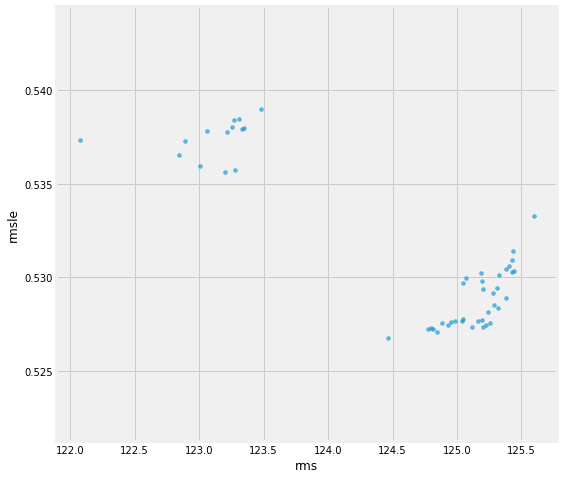

In [209]:
sorted_by_rmsle = [(i[0],i[1],i[3], i[4]) for i in sorted(mods[1], key=lambda x: x[4])[:50]]
scores = [[x[2], x[3]] for x in sorted_by_rmsle]

pd.DataFrame(scores, columns=['rms', 'rmsle']).plot(
    kind='scatter',
    x='rms',
    y='rmsle',
    figsize=(8, 8),
    s=15,
    alpha=.6
);

## Detailed Analysis of the best model of each of these metrics

We also show the plots of the forecasts, these plots are intended to show how the residuals look after fitting the model. I use the best of each of the three metrics and run the analysis

In [210]:
metric_choices = {'aic': 2, 'rms': 3, 'rmsle': 4}

BEST AIC:
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:1684.632334365592
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -1.0996      0.061    -18.131      0.000      -1.218      -0.981
sigma2        96.6483     11.354      8.512      0.000      74.395     118.902


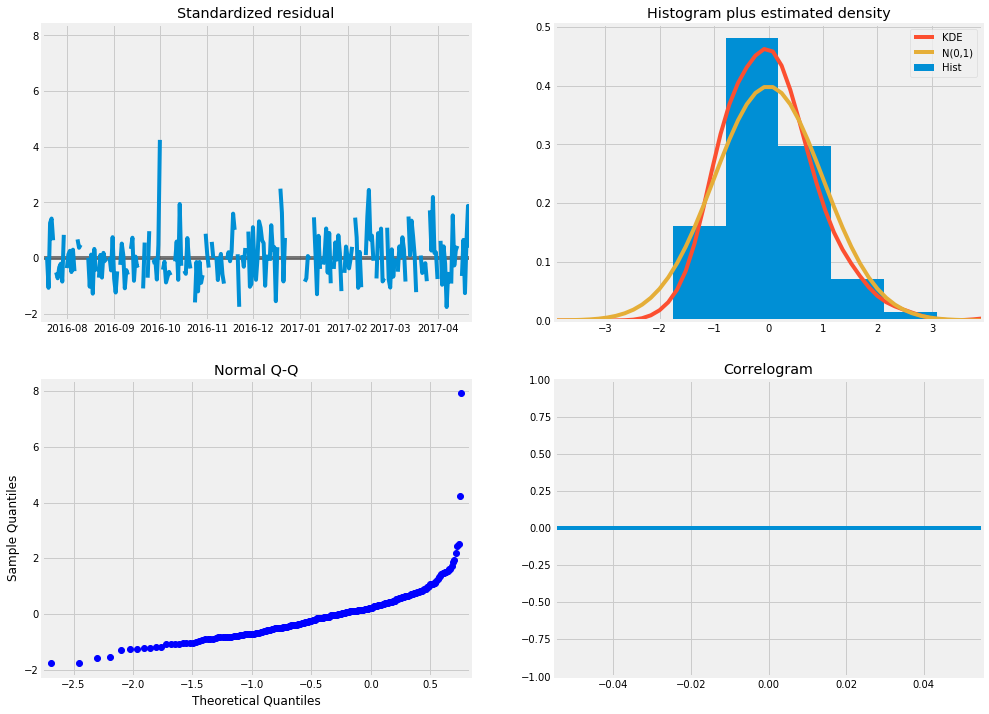

In [211]:
metric_choice=metric_choices['aic']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_aic_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_aic_results = best_aic_mod.fit()

print("BEST AIC:")
print("======================")

print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, best_aic_results.aic))

print(best_aic_results.summary().tables[1])

fig = best_aic_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

You can see above that the estimated density plot looks good—the KDE looks normal. Also notice the residuals look like white noise, which is also good. The Q-Q plot looks pretty ok, but I'm not totally convinced. The biggest concern is the Correlogram's peak at 6. I'm not sure how to understand this, but it seems problematic. 

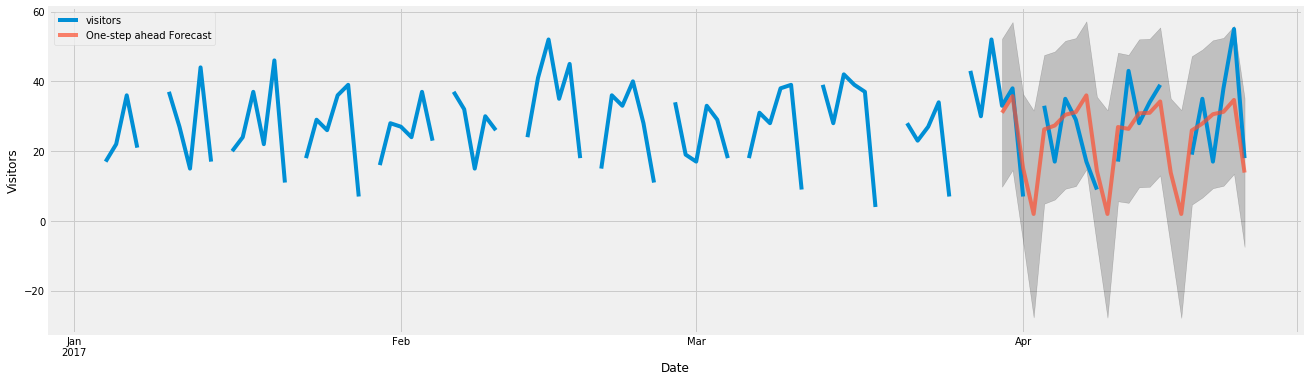

In [212]:
pred_best_aic = best_aic_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_aic = pred_best_aic.conf_int()
ax = test['2017-01-01':].plot(label='observed', figsize=(20, 6))
_ = pred_best_aic.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

_ = ax.fill_between(pred_ci_best_aic.index,
                pred_ci_best_aic.iloc[:, 0],
                pred_ci_best_aic.iloc[:, 1], color='k', alpha=.2)

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Visitors')
_ = plt.legend()

plt.show()

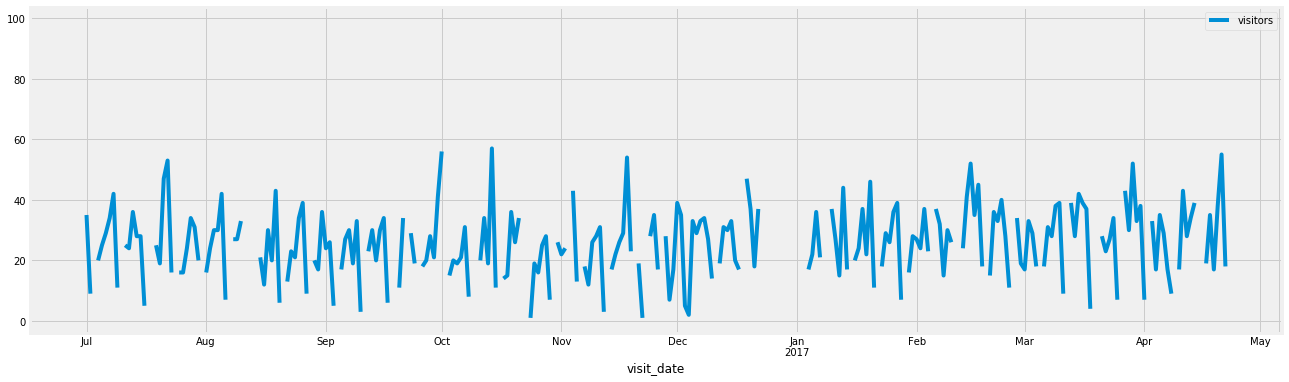

In [214]:
test.plot.line(figsize=(20, 6))

Not the most inspiring plot, looks not lovely.

BEST RMS:


predict  visitors
visit_date                     
2016-07-01   0.000000      35.0
2016-07-02  31.633245       9.0
2016-07-04  11.675478      20.0
2016-07-05  20.806081      25.0
2016-07-06  24.017395      29.0
2016-07-07  28.748053      34.0
2016-07-08  58.547579      42.0
2016-07-09  18.612252      11.0
2016-07-11  22.309479      25.0
2016-07-12  30.004854      24.0
2016-07-13  29.984945      36.0
2016-07-14  38.399170      28.0
2016-07-15  39.962676      28.0
2016-07-16  -2.099744       5.0
2016-07-19  15.718342      25.0
2016-07-20  33.019835      19.0
2016-07-21  19.087911      47.0
2016-07-22  28.241142      53.0
2016-07-23  15.965828      16.0
2016-07-25  32.346779      16.0
2016-07-26  25.482598      16.0
2016-07-27  25.672900      24.0
2016-07-28  37.431063      34.0
2016-07-29  40.322746      31.0
2016-07-30   7.600326      20.0
2016-08-01  20.352884      16.0
2016-08-02  19.628017      24.0
2016-08-03  25.931259      30.0
2016-08-04  36.778946      30.0
2016-08-05  35.682250      42.0
...               ...       ...
2017-03-17  40.511142      37.0
2017-03-18  18.844471       4.0
2017-03-21  27.203351      28.0
2017-03-22  31.088780      23.0
2017-03-23  32.016873      27.0
2017-03-24  37.967751      34.0
2017-03-25  17.234302       7.0
2017-03-27  24.548330      43.0
2017-03-28  29.015383      30.0
2017-03-29  30.791884      52.0
2017-03-30  34.179129      33.0
2017-03-31  40.062559      38.0
2017-04-01  17.567962       7.0
2017-04-03  26.825514      33.0
2017-04-04  28.484126      17.0
2017-04-05  31.643393      35.0
2017-04-06  32.292488      29.0
2017-04-07  39.074439      17.0
2017-04-08  14.888595       9.0
2017-04-10  26.711043      17.0
2017-04-11  25.172829      43.0
2017-04-12  32.749631      28.0
2017-04-13  32.538369      34.0
2017-04-14  36.643638      39.0
2017-04-17  25.870731      19.0
2017-04-18  27.786562      35.0
2017-04-19  31.533259      17.0
2017-04-20  31.428347      38.0
2017-04-21  37.958492      55.0
2017-04-22  19.773001      18.0

[232 rows x 2 columns]

ARIMA(1, 0, 1)x(2, 0, 1, 7) - rms:129.11361719251178
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2590      0.638      0.406      0.685      -0.991       1.509
ma.L1         -0.1088      0.652     -0.167      0.868      -1.387       1.169
ar.S.L7        1.0299      0.120      8.555      0.000       0.794       1.266
ar.S.L14      -0.0272      0.120     -0.226      0.821      -0.262       0.208
ma.S.L7       -0.9466      0.058    -16.190      0.000      -1.061      -0.832
sigma2       117.8371      6.350     18.556      0.000     105.391     130.284


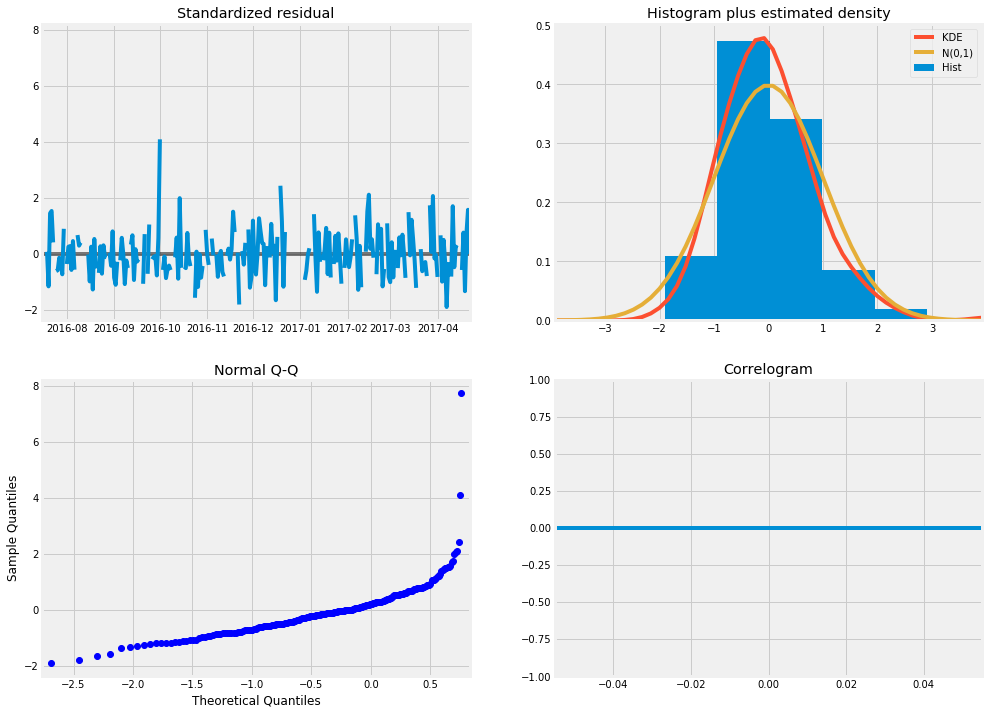

In [226]:
metric_choice=metric_choices['rms']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_rms_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_rms_results = best_rms_mod.fit()

print("BEST RMS:")
print("======================")

comparable_df
comparable_df = pd.DataFrame(
        dict(visitors = test['visitors'], predict = best_rms_results.predict())
    ).dropna()
print('ARIMA{}x{} - rms:{}'.format(param, param_seasonal, rms(comparable_df['visitors'],comparable_df['predict']) ))

print(best_rms_results.summary().tables[1])

fig = best_rms_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

You can see above that the estimated density plot looks good—the KDE looks normal. Also notice the residuals look like white noise, which is also good. The Q-Q plot looks pretty ok, but I'm not totally convinced. The biggest concern is the Correlogram's peak at 6. I'm not sure how to understand this, but it seems problematic. 

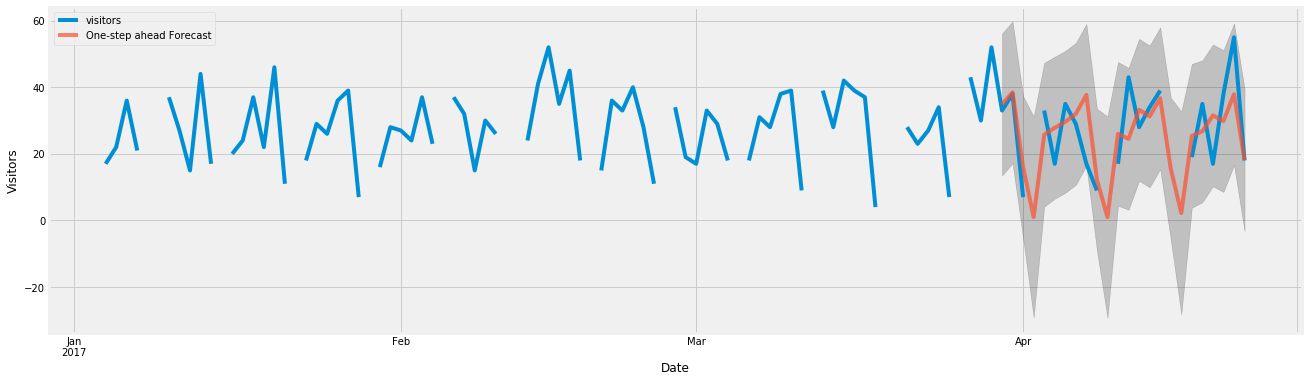

In [218]:
pred_best_rms = best_rms_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_rms = pred_best_rms.conf_int()
ax = test['2017-01-01':].plot(label='observed', figsize=(20, 6))
_ = pred_best_rms.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

_ = ax.fill_between(pred_ci_best_rms.index,
                pred_ci_best_rms.iloc[:, 0],
                pred_ci_best_rms.iloc[:, 1], color='k', alpha=.2)

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Visitors')
_ = plt.legend()

plt.show()

Not the most inspiring plot but I guess not totally awful.

BEST RMSLE:
ARIMA(2, 1, 2)x(2, 1, 1, 7) - rmsle:0.5376590688742166
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2886      1.767     -0.163      0.870      -3.751       3.174
ar.L2          0.0777      0.190      0.408      0.683      -0.295       0.451
ma.L1         -0.6205      1.750     -0.355      0.723      -4.050       2.809
ma.L2         -0.3826      1.784     -0.214      0.830      -3.880       3.115
ar.S.L7        0.0502      0.115      0.437      0.662      -0.175       0.275
ar.S.L14       0.0002      0.118      0.002      0.999      -0.232       0.232
ma.S.L7       -1.0388      0.086    -12.075      0.000      -1.207      -0.870
sigma2       103.2505     29.100      3.548      0.000      46.215     160.286


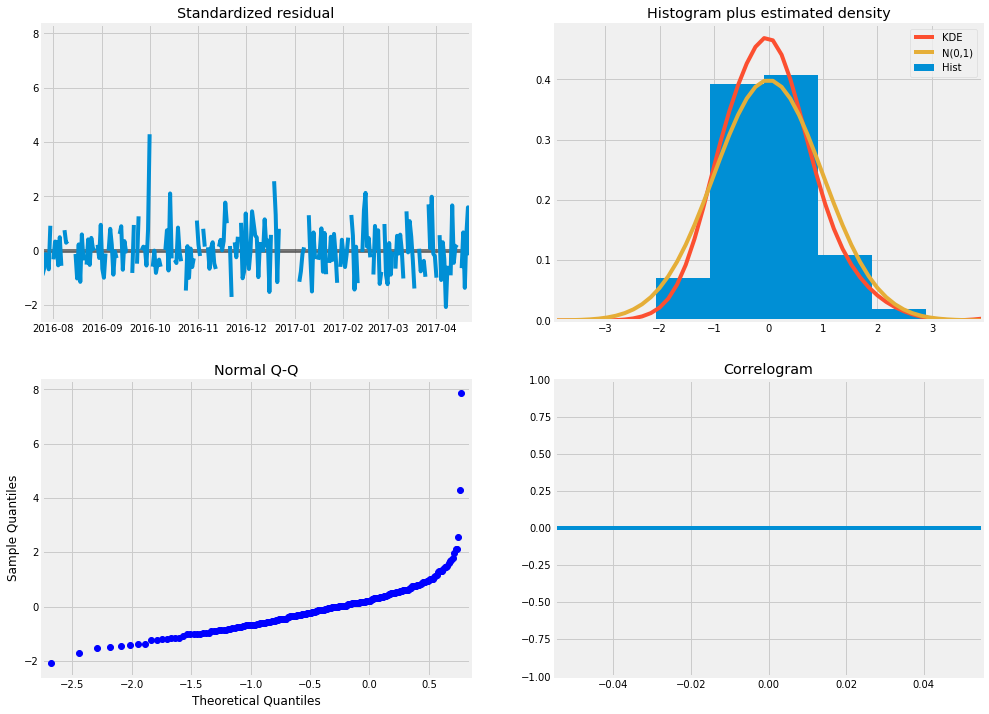

In [229]:
metric_choice=metric_choices['rmsle']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_rmsle_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_rmsle_results = best_rmsle_mod.fit()

print("BEST RMSLE:")
print("======================")

# best_rmsle_results.predict()
comparable_df = pd.DataFrame(
        dict(visitors = test['visitors'], predict = best_rmsle_results.predict().abs())
    ).dropna()
# comparable_df
print('ARIMA{}x{} - rmsle:{}'.format(param, param_seasonal, rmsle(comparable_df['visitors'],comparable_df['predict']) ))
# print('ARIMA{}x{} - rmsle:{}'.format(param, param_seasonal, rmsle(test['visitors'],best_rmsle_results.predict()) ))

print(best_rmsle_results.summary().tables[1])

fig = best_rmsle_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

You can see above that the estimated density plot looks good—the KDE looks normal. Also notice the residuals look like white noise, which is also good. The Q-Q plot looks pretty ok, but I'm not totally convinced. The biggest concern is the Correlogram's peak at 6. I'm not sure how to understand this, but it seems problematic. 

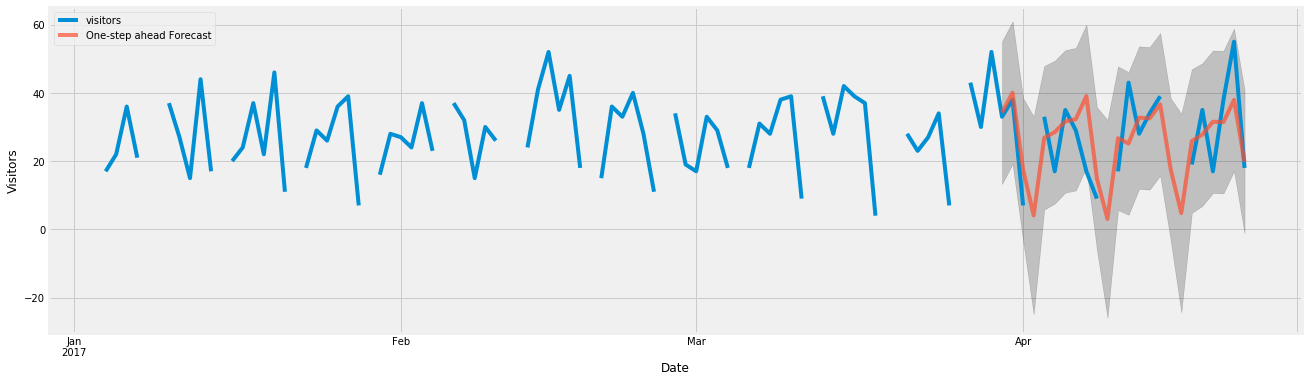

In [230]:
pred_best_rmsle = best_rmsle_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_rmsle = pred_best_rmsle.conf_int()
ax = test['2017-01-01':].plot(label='observed',figsize=(20, 6))
_ = pred_best_rmsle.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_best_rmsle.index,
                pred_ci_best_rmsle.iloc[:, 0],
                pred_ci_best_rmsle.iloc[:, 1], color='k', alpha=.2)

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Visitors')
_ = plt.legend()

plt.show()

Not the most inspiring plot but I guess not totally awful.

## Model construction that builds 40-day windows

Because we have to predict a 40 day window, we should probably be ranking performance based on 40 days windows. This requires some different logic.

In [231]:
import datetime as dt
from IPython.display import display

This is very similar to build_model, but it's a bit more explicit in it's predictions. so it needs to know how long of predictions to make. Quiet makes this not spit out the performance for every single window. 

Here's a basic description of what is happening:
- computes the length of the series you put in
- uses the entire input series and the ord/sord params to build the model
- calls predict on that ending the prediction window at the last day of the series, and starting it `forecast_length` before
- prints the model, and three perf metrics
- returns a tupe that includes the predictions DF, and the three metrics

In [232]:
def build_40day_model(iter_param, series, params_list, static_param=None, forecast_length=40, quiet=False):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
      last = len(series)
      mod = sm.tsa.statespace.SARIMAX(
          series, trend='n', order=ords, seasonal_order=sords
        )
      res = mod.fit(disp=0)
      predictions_frame = res.predict(start = last-forecast_length, end= last-1, dynamic= True)
      if not quiet:
          print('ARIMA{}x{} - predictions:{} - AIC:{:03.5f} - RMS:{:03.5f} - RMSLE:{:03.5f}'.format(
                ords, 
                sords, 
                forecast_length,
                res.aic, 
                rms(series[-forecast_length:], predictions_frame), 
                rmsle(series[-forecast_length:],predictions_frame)
            )
          )  
      return (
            res.get_prediction(start = last-forecast_length, end= last-1, dynamic= True), 
            res.aic, 
            rms(series[-forecast_length:], predictions_frame), 
            rmsle(series[-forecast_length:],predictions_frame)
    )
  except:
    pass

This irritatingly complicated function takes prediction length and number of days back, to generate these pred windows from each date in the region you "care about". This is important for seeing model performance across time using those larger windows. Here's the idea:

- make sure your days back isn't too long
- iterate over a range of 1 to up to `num_days_back - pred_len` because those are all going to be "full windows"
- iterate over the rest of the range to reduce the length of the prediction because they're going to shrink as you come up against the last day of the actuals series
- for the output of both of the above loops:
 - add the three perf values from the series generated _on that day_ to their own columns
 - look at each day in the prediction, and put the prediciton in the row corresponding to that day, in the column corresponding to the number of days out

Now we have rows that correspond to single days, and columns that correspond to time series, which is what we actually want. This gives us the flexibility of having our performance metrics defined in "both directions"

In [22]:
test_models = []
test_ord_param, test_sord_param = (3, 1, 1), (2, 0, 3, 7)
def build_historical_prediction_dataframe(ord_param, sord_param, model_list, dataframe, actuals_column, prediction_length=40, number_of_days_back=100, quiet=False):
    number_of_days_back = min(number_of_days_back, len(dataframe[actuals_column]))
    df_copy = dataframe.copy()
    for i in range(1, number_of_days_back-prediction_length):
        predictions_40, aic_40, rms_40, rmsle_40 = build_40day_model(sord_param, dataframe[actuals_column][:-i], model_list, ord_param, prediction_length, quiet)
        test_models.append(predictions_40.predicted_mean)
        df_copy.loc[predictions_40.predicted_mean.index[0], 'number_of_generated_predictions']=prediction_length
        df_copy.loc[predictions_40.predicted_mean.index[0], 'aic']=float("{0:.4f}".format(aic_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rms']=float("{0:.4f}".format(rms_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rmsle']=float("{0:.5f}".format(rmsle_40))
        for (idx, val) in [(idx,val) for idx, val in predictions_40.predicted_mean.iteritems()]:
            df_copy.loc[idx, (str(1+predictions_40.predicted_mean.index.get_loc(idx))+"_days_out_prediction")]=float("{0:.2f}".format(val))
    for j in range(prediction_length):
        predictions_40, aic_40, rms_40, rmsle_40 = build_40day_model(sord_param, dataframe[actuals_column], model_list, ord_param, prediction_length-j, quiet)
        test_models.append(predictions_40.predicted_mean)
        df_copy.loc[predictions_40.predicted_mean.index[0], 'number_of_generated_predictions']=prediction_length-j
        df_copy.loc[predictions_40.predicted_mean.index[0], 'aic']=float("{0:.4f}".format(aic_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rms']=float("{0:.4f}".format(rms_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rmsle']=float("{0:.5f}".format(rmsle_40))
        test_models.append(predictions_40.predicted_mean)
        for (idx, val) in [(idx,val) for idx, val in predictions_40.predicted_mean.iteritems()]:
            df_copy.loc[idx, (str(1+predictions_40.predicted_mean.index.get_loc(idx))+"_days_out_prediction")]=float("{0:.4f}".format(val))
    return df_copy
historical_prediction_output = build_historical_prediction_dataframe(test_ord_param, test_sord_param, test_models, test, 'visitors', 40, 100)
print("******Finished Predictions*******")

ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2096.31748 - RMS:160.67902 - RMSLE:0.58794
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2089.37777 - RMS:160.47566 - RMSLE:0.58056
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2082.18380 - RMS:178.93165 - RMSLE:0.62281
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2075.33224 - RMS:169.08032 - RMSLE:0.60521
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2067.91465 - RMS:155.23170 - RMSLE:0.54354
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2058.78935 - RMS:151.23229 - RMSLE:0.52457
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2049.71265 - RMS:146.13326 - RMSLE:0.52948
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2041.90840 - RMS:145.45834 - RMSLE:0.53056
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2033.49741 - RMS:166.82325 - RMSLE:0.50912
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2026.05062 - RMS:189.46756 - RMSLE:0.51586
ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:2017.5523

All of the above has been built into the dataframe `historical_prediction_output` which we see is lower triangular if we look at the `X` most recent entries where `X` is the number_of_days_back. We also notice it has columns for `n_days_out_prediction` for each `n<=prediction_length`:

In [23]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    historical_prediction_output[-100:]

air_store_id  visit_date  visitors  \
visit_date                                               
2016-12-28  air_0f0cdeee6c9bf3d7  2016-12-28        45   
2016-12-29  air_0f0cdeee6c9bf3d7  2016-12-29        33   
2016-12-30  air_0f0cdeee6c9bf3d7  2016-12-30        47   
2017-01-02  air_0f0cdeee6c9bf3d7  2017-01-02        10   
2017-01-03  air_0f0cdeee6c9bf3d7  2017-01-03        38   
2017-01-04  air_0f0cdeee6c9bf3d7  2017-01-04        31   
2017-01-06  air_0f0cdeee6c9bf3d7  2017-01-06        22   
2017-01-07  air_0f0cdeee6c9bf3d7  2017-01-07        45   
2017-01-08  air_0f0cdeee6c9bf3d7  2017-01-08        17   
2017-01-09  air_0f0cdeee6c9bf3d7  2017-01-09        32   
2017-01-10  air_0f0cdeee6c9bf3d7  2017-01-10        16   
2017-01-11  air_0f0cdeee6c9bf3d7  2017-01-11        11   
2017-01-12  air_0f0cdeee6c9bf3d7  2017-01-12        34   
2017-01-13  air_0f0cdeee6c9bf3d7  2017-01-13        33   
2017-01-14  air_0f0cdeee6c9bf3d7  2017-01-14        41   
2017-01-15  air_0f0cdeee6c9bf3d7  2017-01-15        25   
2017-01-18  air_0f0cdeee6c9bf3d7  2017-01-18        24   
2017-01-19  air_0f0cdeee6c9bf3d7  2017-01-19        22   
2017-01-20  air_0f0cdeee6c9bf3d7  2017-01-20        38   
2017-01-21  air_0f0cdeee6c9bf3d7  2017-01-21        47   
2017-01-22  air_0f0cdeee6c9bf3d7  2017-01-22        39   
2017-01-23  air_0f0cdeee6c9bf3d7  2017-01-23        13   
2017-01-25  air_0f0cdeee6c9bf3d7  2017-01-25        11   
2017-01-26  air_0f0cdeee6c9bf3d7  2017-01-26        23   
2017-01-27  air_0f0cdeee6c9bf3d7  2017-01-27        39   
2017-01-28  air_0f0cdeee6c9bf3d7  2017-01-28        47   
2017-01-29  air_0f0cdeee6c9bf3d7  2017-01-29        28   
2017-01-30  air_0f0cdeee6c9bf3d7  2017-01-30        11   
2017-02-01  air_0f0cdeee6c9bf3d7  2017-02-01        12   
2017-02-02  air_0f0cdeee6c9bf3d7  2017-02-02         3   
2017-02-03  air_0f0cdeee6c9bf3d7  2017-02-03        21   
2017-02-04  air_0f0cdeee6c9bf3d7  2017-02-04        41   
2017-02-05  air_0f0cdeee6c9bf3d7  2017-02-05        50   
2017-02-06  air_0f0cdeee6c9bf3d7  2017-02-06         6   
2017-02-08  air_0f0cdeee6c9bf3d7  2017-02-08         8   
2017-02-09  air_0f0cdeee6c9bf3d7  2017-02-09         1   
2017-02-10  air_0f0cdeee6c9bf3d7  2017-02-10        47   
2017-02-11  air_0f0cdeee6c9bf3d7  2017-02-11        33   
2017-02-12  air_0f0cdeee6c9bf3d7  2017-02-12        31   
2017-02-13  air_0f0cdeee6c9bf3d7  2017-02-13         2   
2017-02-14  air_0f0cdeee6c9bf3d7  2017-02-14         8   
2017-02-15  air_0f0cdeee6c9bf3d7  2017-02-15        19   
2017-02-16  air_0f0cdeee6c9bf3d7  2017-02-16        34   
2017-02-17  air_0f0cdeee6c9bf3d7  2017-02-17        37   
2017-02-18  air_0f0cdeee6c9bf3d7  2017-02-18        54   
2017-02-19  air_0f0cdeee6c9bf3d7  2017-02-19        36   
2017-02-20  air_0f0cdeee6c9bf3d7  2017-02-20        15   
2017-02-22  air_0f0cdeee6c9bf3d7  2017-02-22        19   
2017-02-23  air_0f0cdeee6c9bf3d7  2017-02-23        20   
2017-02-24  air_0f0cdeee6c9bf3d7  2017-02-24        27   
2017-02-25  air_0f0cdeee6c9bf3d7  2017-02-25        44   
2017-02-26  air_0f0cdeee6c9bf3d7  2017-02-26        68   
2017-02-27  air_0f0cdeee6c9bf3d7  2017-02-27        26   
2017-03-01  air_0f0cdeee6c9bf3d7  2017-03-01        14   
2017-03-02  air_0f0cdeee6c9bf3d7  2017-03-02        18   
2017-03-03  air_0f0cdeee6c9bf3d7  2017-03-03        36   
2017-03-04  air_0f0cdeee6c9bf3d7  2017-03-04        43   
2017-03-05  air_0f0cdeee6c9bf3d7  2017-03-05        14   
2017-03-06  air_0f0cdeee6c9bf3d7  2017-03-06        39   
2017-03-08  air_0f0cdeee6c9bf3d7  2017-03-08        34   
2017-03-09  air_0f0cdeee6c9bf3d7  2017-03-09        28   
2017-03-10  air_0f0cdeee6c9bf3d7  2017-03-10        31   
2017-03-11  air_0f0cdeee6c9bf3d7  2017-03-11        42   
2017-03-12  air_0f0cdeee6c9bf3d7  2017-03-12        32   
2017-03-13  air_0f0cdeee6c9bf3d7  2017-03-13        23   
2017-03-15  air_0f0cdeee6c9bf3d7  2017-03-15        31   
2017-03-16  air_0f0cdeee6c9bf3d7  2017-03-16        30   
2017-03-17  air_0f

Let's now build a simple way to apply a weighting metric across the RMSLE for pred_len windows to turn this into an overall performance value:

I use code from here: https://stackoverflow.com/questions/25649412/exponential-decay-on-python-pandas-dataframe

In [24]:
dataset = historical_prediction_output[['number_of_generated_predictions', 'aic', 'rms', 'rmsle']].dropna(axis=0, how='any')

print(dataset.describe())

weightspace = np.exp(np.linspace(len(dataset), 0, num=len(dataset))*-0.05)
def rollingsum(array):
    weights = weightspace[0-len(array):]
    # Convolve the array and the weights to obtain the result
    a = np.dot(array, weights).sum()
    return a

print(f"Means: \n{dataset.mean()} \nWeighted sum performance values: \n{pd.expanding_apply(dataset, rollingsum).iloc[-1]}")

       number_of_generated_predictions          aic         rms      rmsle
count                        99.000000    99.000000   99.000000  99.000000
mean                         32.121212  1961.256291  246.600059   0.709574
std                          12.119535   163.870535   93.873882   0.157095
min                           1.000000  1626.607200  145.458300   0.420560
25%                          25.500000  1820.001200  207.086800   0.597335
50%                          40.000000  2026.050600  239.373400   0.718020
75%                          40.000000  2110.239500  262.334400   0.844790
max                          40.000000  2110.239500  984.621700   1.015100
Means: 
number_of_generated_predictions      32.121212
aic                                1961.256291
rms                                 246.600059
rmsle                                 0.709574
dtype: float64 
Weighted sum performance values: 
number_of_generated_predictions      352.054392
aic                            

Here are the "vertical" performance visualizations; by this I mean, how the actuals compare to the predictions based on number of days out. You'll  notice that in these, the first day of the prediction is changing, which aligns with the first non-null date.

Prediction Start: 2016-12-29 00:00:00 — Prediction Column: 1_days_out_prediction — RMS: 173.9858129639394 — RMSLE: 0.6211788110162186


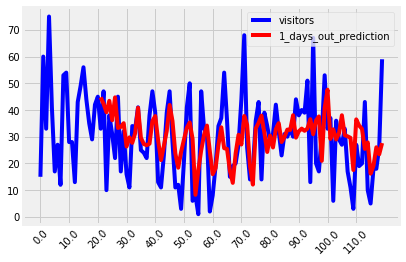

Prediction Start: 2016-12-30 00:00:00 — Prediction Column: 2_days_out_prediction — RMS: 177.36980083785713 — RMSLE: 0.6337187353497257


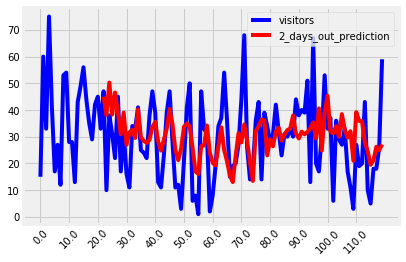

Prediction Start: 2017-01-02 00:00:00 — Prediction Column: 3_days_out_prediction — RMS: 179.1387889726804 — RMSLE: 0.6388335179029161


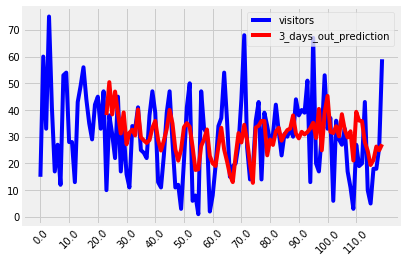

Prediction Start: 2017-01-03 00:00:00 — Prediction Column: 4_days_out_prediction — RMS: 173.6414405167708 — RMSLE: 0.6376546815506983


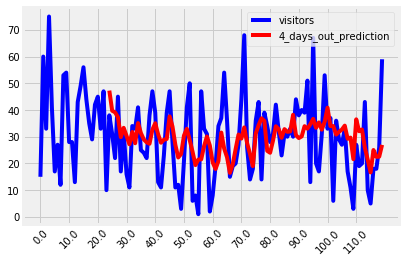

Prediction Start: 2017-01-04 00:00:00 — Prediction Column: 5_days_out_prediction — RMS: 175.5323300408421 — RMSLE: 0.6422008461635975


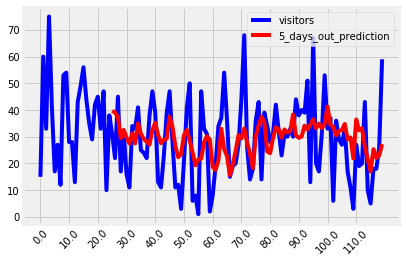

Prediction Start: 2017-01-06 00:00:00 — Prediction Column: 6_days_out_prediction — RMS: 181.52586305510638 — RMSLE: 0.6569829833067599


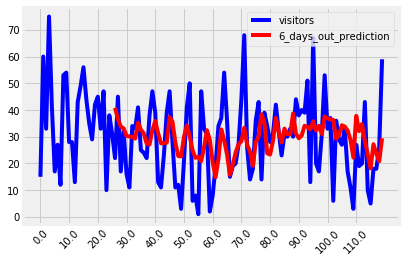

Prediction Start: 2017-01-07 00:00:00 — Prediction Column: 7_days_out_prediction — RMS: 201.25898259741933 — RMSLE: 0.6864590984062977


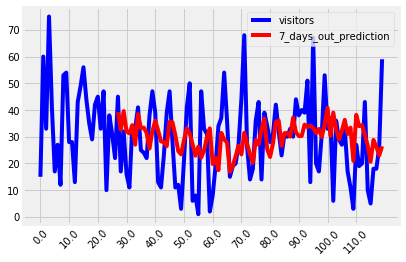

Prediction Start: 2017-01-08 00:00:00 — Prediction Column: 8_days_out_prediction — RMS: 223.52742359010864 — RMSLE: 0.7189082031094739


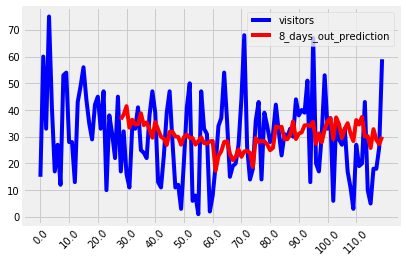

Prediction Start: 2017-01-09 00:00:00 — Prediction Column: 9_days_out_prediction — RMS: 227.9726954501099 — RMSLE: 0.7258222535807022


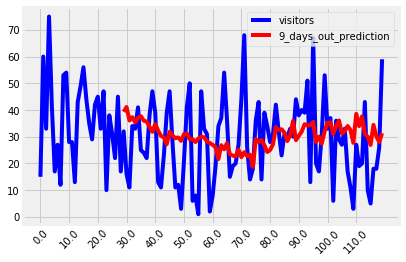

Prediction Start: 2017-01-10 00:00:00 — Prediction Column: 10_days_out_prediction — RMS: 229.10683253977777 — RMSLE: 0.729289902913022


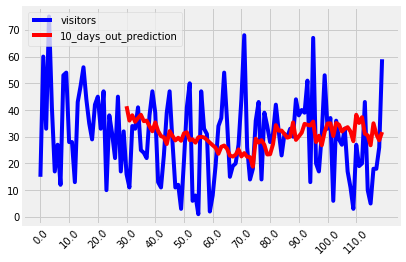

Prediction Start: 2017-01-11 00:00:00 — Prediction Column: 11_days_out_prediction — RMS: 223.58087404898873 — RMSLE: 0.7257326974899216


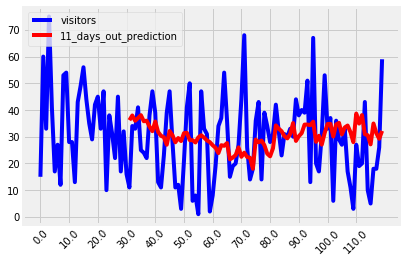

Prediction Start: 2017-01-12 00:00:00 — Prediction Column: 12_days_out_prediction — RMS: 221.78280163352272 — RMSLE: 0.7230275327839386


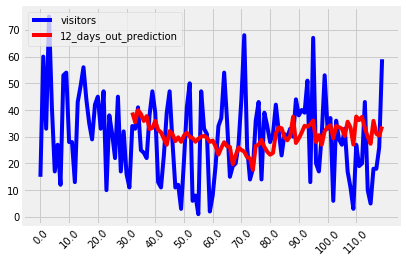

Prediction Start: 2017-01-13 00:00:00 — Prediction Column: 13_days_out_prediction — RMS: 230.5910353218391 — RMSLE: 0.7356641892898065


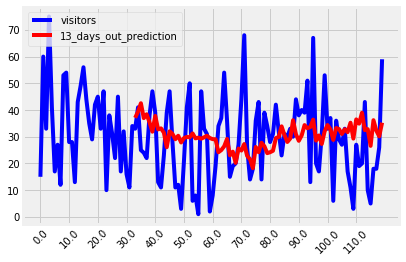

Prediction Start: 2017-01-14 00:00:00 — Prediction Column: 14_days_out_prediction — RMS: 239.84284757953492 — RMSLE: 0.7488897952190555


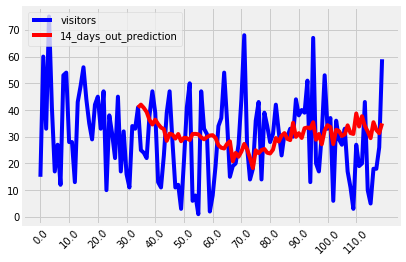

Prediction Start: 2017-01-15 00:00:00 — Prediction Column: 15_days_out_prediction — RMS: 247.93576514729418 — RMSLE: 0.7557709862270079


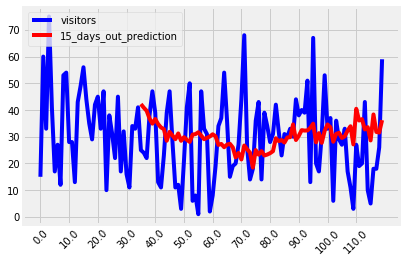

Prediction Start: 2017-01-18 00:00:00 — Prediction Column: 16_days_out_prediction — RMS: 247.50330489916672 — RMSLE: 0.7584273030729033


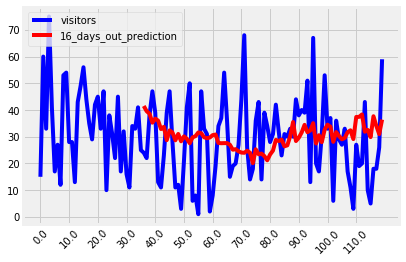

Prediction Start: 2017-01-19 00:00:00 — Prediction Column: 17_days_out_prediction — RMS: 242.83646507795183 — RMSLE: 0.7561185039971792


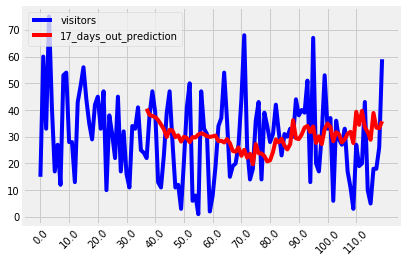

Prediction Start: 2017-01-20 00:00:00 — Prediction Column: 18_days_out_prediction — RMS: 241.28970789231704 — RMSLE: 0.7577292762756733


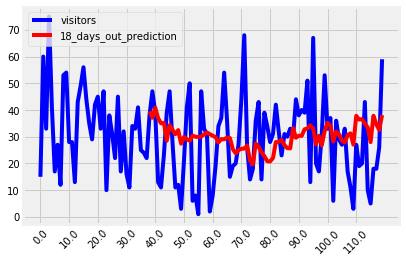

Prediction Start: 2017-01-21 00:00:00 — Prediction Column: 19_days_out_prediction — RMS: 253.8331953091358 — RMSLE: 0.7741419865345818


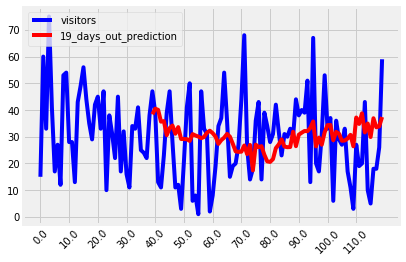

Prediction Start: 2017-01-22 00:00:00 — Prediction Column: 20_days_out_prediction — RMS: 260.99406720999997 — RMSLE: 0.782906408267418


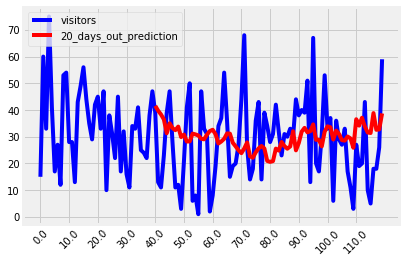

Prediction Start: 2017-01-23 00:00:00 — Prediction Column: 21_days_out_prediction — RMS: 271.59421724025316 — RMSLE: 0.7901229645067019


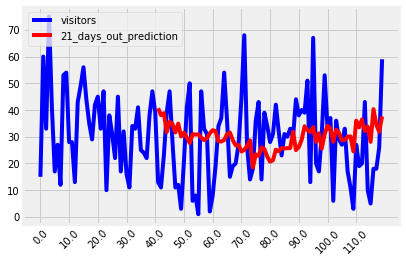

Prediction Start: 2017-01-25 00:00:00 — Prediction Column: 22_days_out_prediction — RMS: 261.60279799756415 — RMSLE: 0.7850119572321459


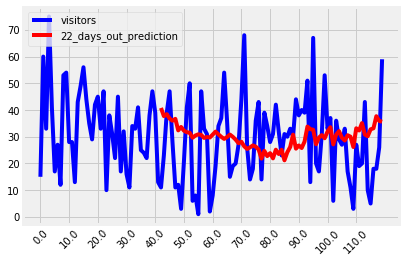

Prediction Start: 2017-01-26 00:00:00 — Prediction Column: 23_days_out_prediction — RMS: 248.32376960168833 — RMSLE: 0.7745874314271503


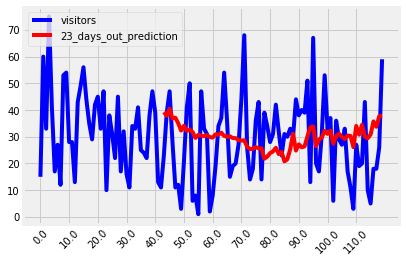

Prediction Start: 2017-01-27 00:00:00 — Prediction Column: 24_days_out_prediction — RMS: 245.30129677263162 — RMSLE: 0.776613077161176


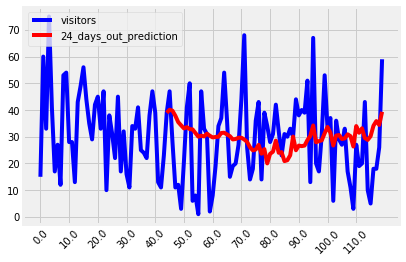

Prediction Start: 2017-01-28 00:00:00 — Prediction Column: 25_days_out_prediction — RMS: 256.6686482698667 — RMSLE: 0.7878775985060813


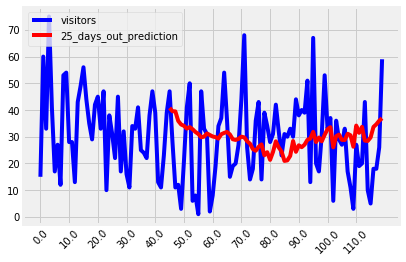

Prediction Start: 2017-01-29 00:00:00 — Prediction Column: 26_days_out_prediction — RMS: 266.9405721840541 — RMSLE: 0.8009156404044965


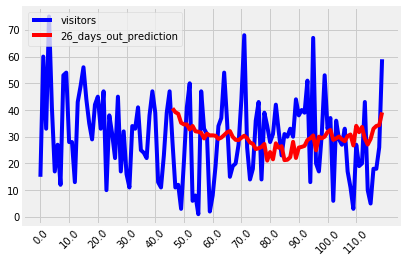

Prediction Start: 2017-01-30 00:00:00 — Prediction Column: 27_days_out_prediction — RMS: 270.4457187389041 — RMSLE: 0.8063196819130755


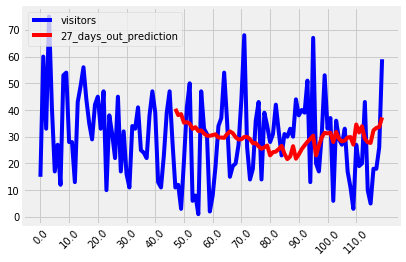

Prediction Start: 2017-02-01 00:00:00 — Prediction Column: 28_days_out_prediction — RMS: 265.49045545166666 — RMSLE: 0.8007002155227702


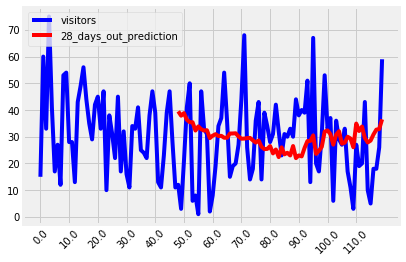

Prediction Start: 2017-02-02 00:00:00 — Prediction Column: 29_days_out_prediction — RMS: 262.46569148084507 — RMSLE: 0.7978994274387271


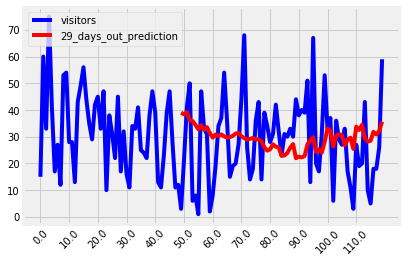

Prediction Start: 2017-02-03 00:00:00 — Prediction Column: 30_days_out_prediction — RMS: 251.28944062899993 — RMSLE: 0.7619252993768086


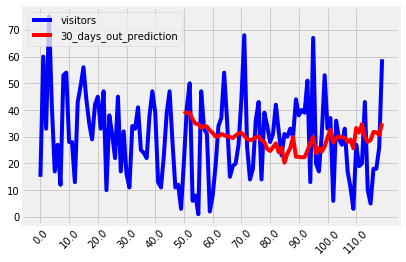

Prediction Start: 2017-02-04 00:00:00 — Prediction Column: 31_days_out_prediction — RMS: 252.3305056636232 — RMSLE: 0.766139563483401


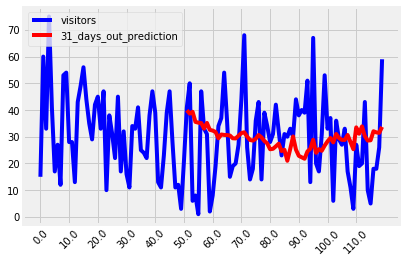

Prediction Start: 2017-02-05 00:00:00 — Prediction Column: 32_days_out_prediction — RMS: 264.27349436941176 — RMSLE: 0.7778044114183349


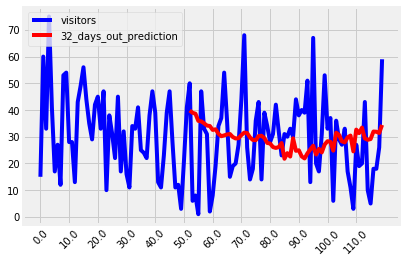

Prediction Start: 2017-02-06 00:00:00 — Prediction Column: 33_days_out_prediction — RMS: 271.7843571664179 — RMSLE: 0.7884619611819512


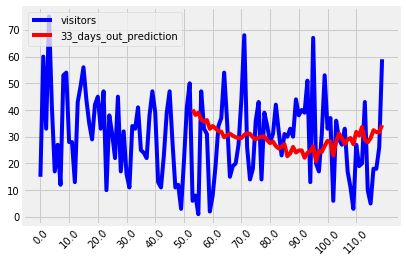

Prediction Start: 2017-02-08 00:00:00 — Prediction Column: 34_days_out_prediction — RMS: 256.9598236906061 — RMSLE: 0.7625663593412869


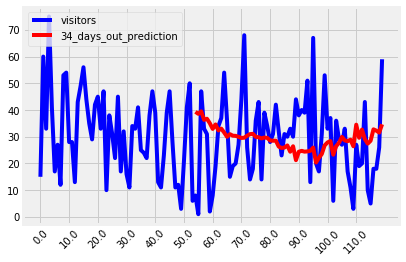

Prediction Start: 2017-02-09 00:00:00 — Prediction Column: 35_days_out_prediction — RMS: 244.87822218369234 — RMSLE: 0.7463007496971014


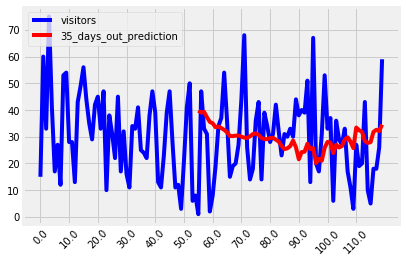

Prediction Start: 2017-02-10 00:00:00 — Prediction Column: 36_days_out_prediction — RMS: 228.8298248520312 — RMSLE: 0.6551904411375661


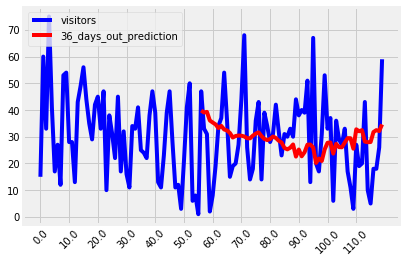

Prediction Start: 2017-02-11 00:00:00 — Prediction Column: 37_days_out_prediction — RMS: 229.50400714714291 — RMSLE: 0.6625403695483351


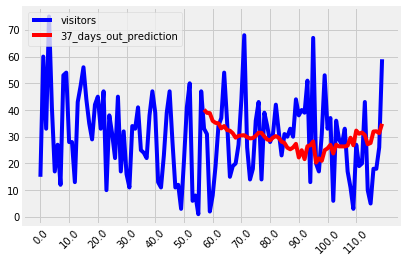

Prediction Start: 2017-02-12 00:00:00 — Prediction Column: 38_days_out_prediction — RMS: 237.71677949193548 — RMSLE: 0.669525293954424


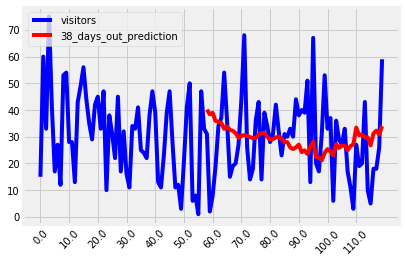

Prediction Start: 2017-02-13 00:00:00 — Prediction Column: 39_days_out_prediction — RMS: 240.76558823245904 — RMSLE: 0.6684571040785843


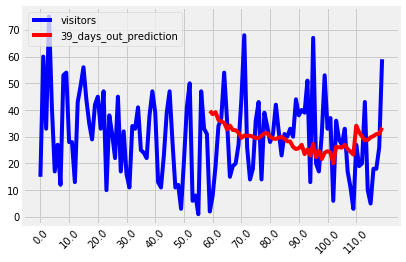

Prediction Start: 2017-02-14 00:00:00 — Prediction Column: 40_days_out_prediction — RMS: 223.94644832016667 — RMSLE: 0.5824941044923242


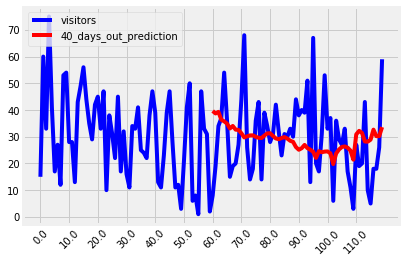

In [25]:
_ = historical_prediction_output.plot(label='Dynamic Forecast', ax=ax)

for i in range(40):
    col_name = str((i+1))+"_days_out_prediction"
    comp_df =historical_prediction_output[['visitors', col_name]].dropna(axis=0, how='any')
    print(f"Prediction Start: {comp_df.index[0]} — Prediction Column: {col_name} — RMS: {rms(comp_df['visitors'],comp_df[col_name])} — RMSLE: {rmsle(comp_df['visitors'],comp_df[col_name])}")
    _ = plt.tight_layout()
    _ = plt.plot(figsize=(12, 6))
    _ = plt.plot(historical_prediction_output['visit_date'][-120:], historical_prediction_output['visitors'][-120:], 'b-', label='visitors')
    _ = plt.plot(historical_prediction_output['visit_date'][-120:], historical_prediction_output[col_name][-120:], 'r-', label=col_name)
    _ = ax = plt.axes()
    _ = ax.set_xticks(ax.get_xticks()[::10])
    _ = ax.set_xticklabels(ax.get_xticks(), rotation=45)
    _ = plt.legend(loc='best')
    _ = plt.show()

Here are the 'horizontal' plots for each day of the different predictions based on number of days out those predictions are made

Predictions for Date: 2016-12-29 00:00:00 — Number of predictions: 1


2016-12-29
count        1.00
mean        44.77
std           NaN
min         44.77
25%         44.77
50%         44.77
75%         44.77
max         44.77

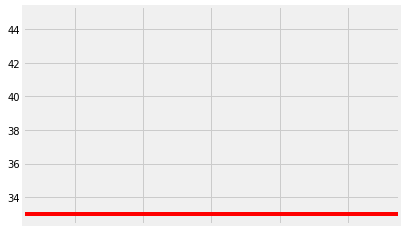

Predictions for Date: 2016-12-30 00:00:00 — Number of predictions: 2


2016-12-30
count    2.000000
mean    43.675000
std      1.916259
min     42.320000
25%     42.997500
50%     43.675000
75%     44.352500
max     45.030000

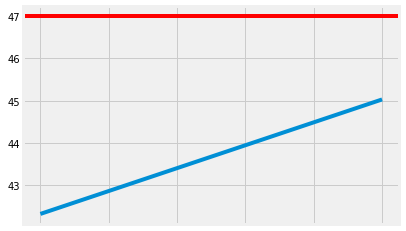

Predictions for Date: 2017-01-02 00:00:00 — Number of predictions: 3


2017-01-02
count    3.000000
mean    38.456667
std      0.609125
min     38.100000
25%     38.105000
50%     38.110000
75%     38.635000
max     39.160000

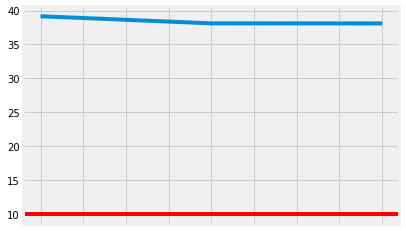

Predictions for Date: 2017-01-03 00:00:00 — Number of predictions: 4


2017-01-03
count     4.00000
mean     47.85500
std       3.27664
min      43.45000
25%      46.31500
50%      48.77000
75%      50.31000
max      50.43000

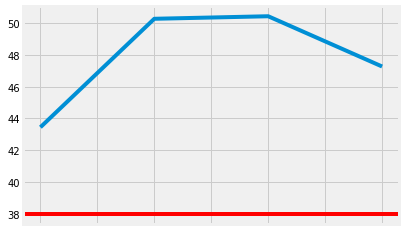

Predictions for Date: 2017-01-04 00:00:00 — Number of predictions: 5


2017-01-04
count    5.000000
mean    38.446000
std      1.442889
min     36.170000
25%     38.320000
50%     38.350000
75%     39.660000
max     39.730000

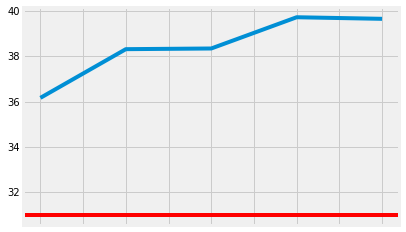

Predictions for Date: 2017-01-06 00:00:00 — Number of predictions: 6


2017-01-06
count    6.000000
mean    42.878333
std      3.628528
min     39.090000
25%     39.557500
50%     42.790000
75%     46.105000
max     46.910000

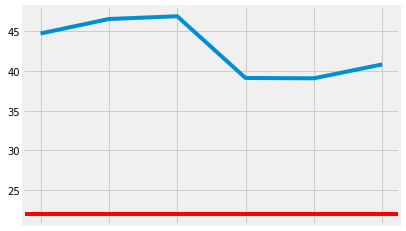

Predictions for Date: 2017-01-07 00:00:00 — Number of predictions: 7


2017-01-07
count    7.000000
mean    37.322857
std      2.031984
min     33.270000
25%     36.935000
50%     37.330000
75%     38.810000
max     39.170000

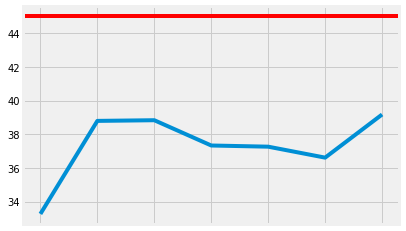

Predictions for Date: 2017-01-08 00:00:00 — Number of predictions: 8


2017-01-08
count    8.000000
mean    32.257500
std      2.371183
min     29.440000
25%     30.642500
50%     31.945000
75%     33.700000
max     36.520000

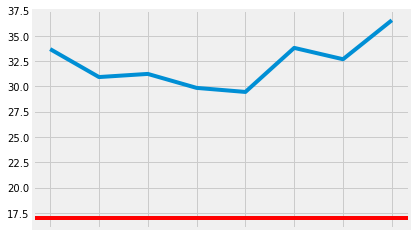

Predictions for Date: 2017-01-09 00:00:00 — Number of predictions: 9


2017-01-09
count    9.000000
mean    36.604444
std      3.022665
min     32.550000
25%     33.330000
50%     38.300000
75%     39.090000
max     39.600000

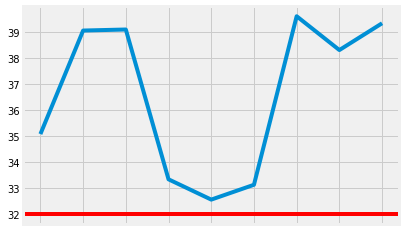

Predictions for Date: 2017-01-10 00:00:00 — Number of predictions: 10


2017-01-10
count   10.000000
mean    32.677000
std      6.224486
min     26.330000
25%     27.800000
50%     30.305000
75%     38.852500
max     41.440000

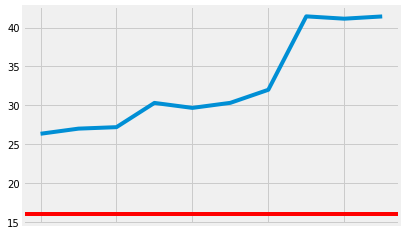

Predictions for Date: 2017-01-11 00:00:00 — Number of predictions: 11


2017-01-11
count   11.000000
mean    31.863636
std      3.255332
min     27.180000
25%     29.920000
50%     31.490000
75%     34.715000
max     36.180000

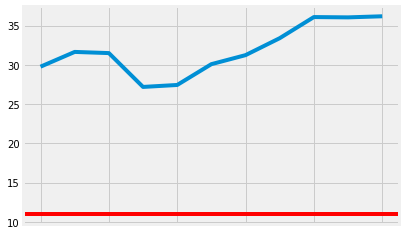

Predictions for Date: 2017-01-12 00:00:00 — Number of predictions: 12


2017-01-12
count   12.000000
mean    34.077500
std      3.651939
min     27.710000
25%     31.665000
50%     33.490000
75%     37.485000
max     39.070000

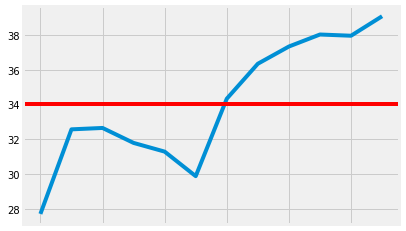

Predictions for Date: 2017-01-13 00:00:00 — Number of predictions: 13


2017-01-13
count   13.000000
mean    32.066923
std      3.713954
min     27.050000
25%     29.300000
50%     31.360000
75%     35.450000
max     37.070000

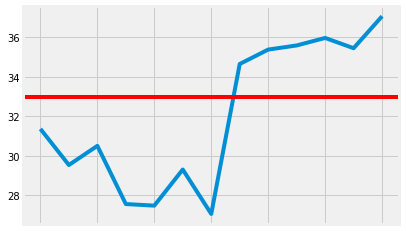

Predictions for Date: 2017-01-14 00:00:00 — Number of predictions: 14


2017-01-14
count   14.000000
mean    37.943571
std      2.334697
min     34.680000
25%     35.715000
50%     37.765000
75%     40.132500
max     40.920000

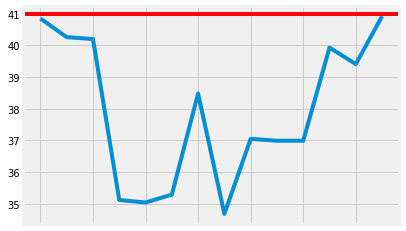

Predictions for Date: 2017-01-15 00:00:00 — Number of predictions: 15


2017-01-15
count   15.000000
mean    35.707333
std      4.819654
min     29.630000
25%     31.235000
50%     37.690000
75%     38.665000
max     42.540000

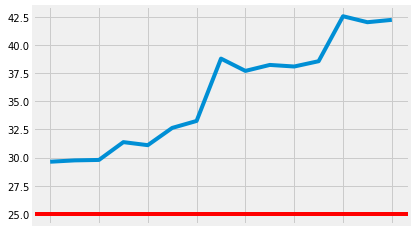

Predictions for Date: 2017-01-18 00:00:00 — Number of predictions: 16


2017-01-18
count    16.00000
mean     34.08000
std       4.71846
min      27.28000
25%      29.13000
50%      35.07500
75%      36.24750
max      41.51000

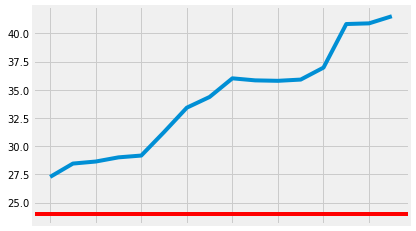

Predictions for Date: 2017-01-19 00:00:00 — Number of predictions: 17


2017-01-19
count   17.000000
mean    33.842353
std      5.194284
min     26.810000
25%     27.920000
50%     35.670000
75%     38.400000
max     40.500000

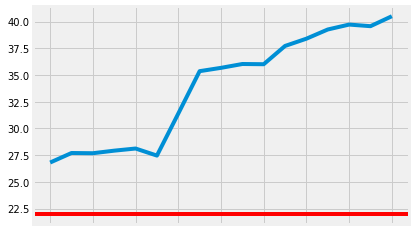

Predictions for Date: 2017-01-20 00:00:00 — Number of predictions: 18


2017-01-20
count   18.000000
mean    32.437222
std      4.552354
min     25.600000
25%     27.732500
50%     33.315000
75%     36.067500
max     39.530000

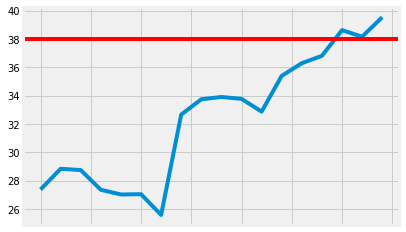

Predictions for Date: 2017-01-21 00:00:00 — Number of predictions: 19


2017-01-21
count   19.000000
mean    33.746842
std      2.294285
min     29.630000
25%     32.085000
50%     33.290000
75%     35.080000
max     38.380000

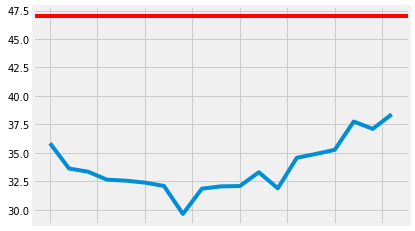

Predictions for Date: 2017-01-22 00:00:00 — Number of predictions: 20


2017-01-22
count   20.000000
mean    36.827500
std      1.982361
min     34.760000
25%     35.527500
50%     35.985000
75%     37.437500
max     41.570000

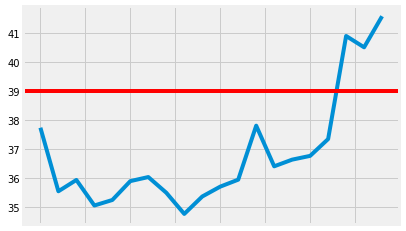

Predictions for Date: 2017-01-23 00:00:00 — Number of predictions: 21


2017-01-23
count   21.000000
mean    33.520952
std      3.645955
min     28.240000
25%     31.320000
50%     32.560000
75%     36.020000
max     40.650000

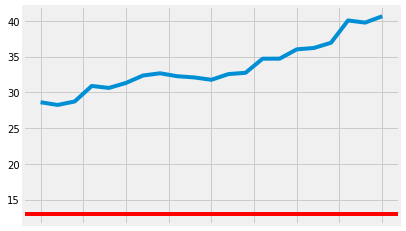

Predictions for Date: 2017-01-25 00:00:00 — Number of predictions: 22


2017-01-25
count   22.000000
mean    31.354545
std      4.797039
min     21.250000
25%     27.877500
50%     31.000000
75%     34.295000
max     40.770000

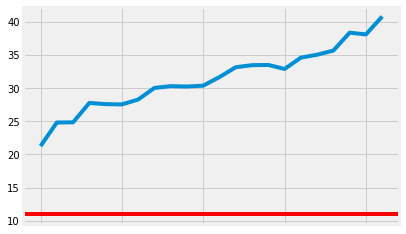

Predictions for Date: 2017-01-26 00:00:00 — Number of predictions: 23


2017-01-26
count   23.000000
mean    31.836957
std      3.792370
min     26.510000
25%     28.890000
50%     29.830000
75%     34.445000
max     39.190000

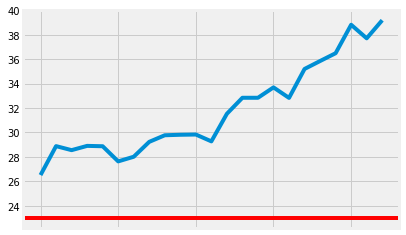

Predictions for Date: 2017-01-27 00:00:00 — Number of predictions: 24


2017-01-27
count   24.000000
mean    30.213333
std      3.758453
min     26.080000
25%     27.250000
50%     28.930000
75%     31.837500
max     38.950000

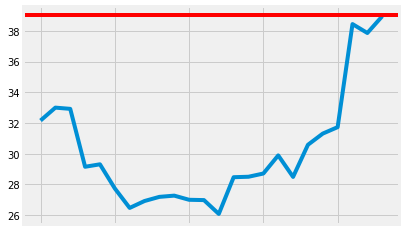

Predictions for Date: 2017-01-28 00:00:00 — Number of predictions: 25


2017-01-28
count   25.000000
mean    35.469200
std      3.553857
min     31.150000
25%     32.100000
50%     35.040000
75%     37.620000
max     41.890000

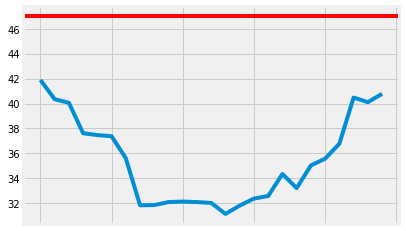

Predictions for Date: 2017-01-29 00:00:00 — Number of predictions: 26


2017-01-29
count   26.000000
mean    33.936538
std      2.991032
min     30.320000
25%     31.180000
50%     33.785000
75%     35.572500
max     40.620000

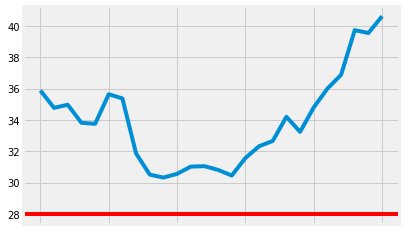

Predictions for Date: 2017-01-30 00:00:00 — Number of predictions: 27


2017-01-30
count   27.000000
mean    30.855185
std      4.635623
min     23.680000
25%     28.150000
50%     29.440000
75%     32.030000
max     40.450000

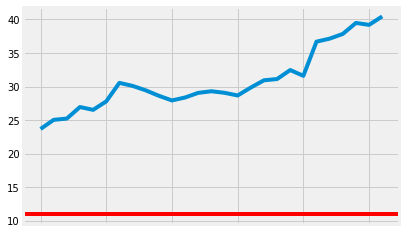

Predictions for Date: 2017-02-01 00:00:00 — Number of predictions: 28


2017-02-01
count   28.000000
mean    30.182500
std      5.703205
min     18.410000
25%     28.290000
50%     30.765000
75%     34.070000
max     39.500000

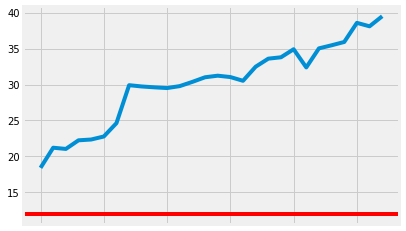

Predictions for Date: 2017-02-02 00:00:00 — Number of predictions: 29


2017-02-02
count   29.000000
mean    29.363448
std      4.585483
min     22.650000
25%     27.020000
50%     28.370000
75%     32.310000
max     39.000000

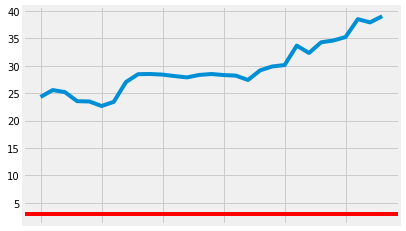

Predictions for Date: 2017-02-03 00:00:00 — Number of predictions: 30


2017-02-03
count   30.000000
mean    32.010333
std      2.957533
min     28.730000
25%     29.905000
50%     30.885000
75%     33.695000
max     39.530000

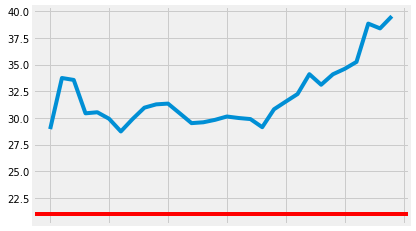

Predictions for Date: 2017-02-04 00:00:00 — Number of predictions: 31


2017-02-04
count   31.000000
mean    32.609677
std      3.117155
min     28.200000
25%     29.815000
50%     32.170000
75%     34.405000
max     39.910000

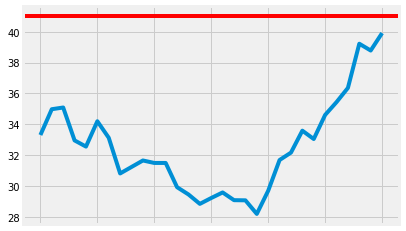

Predictions for Date: 2017-02-05 00:00:00 — Number of predictions: 32


2017-02-05
count   32.000000
mean    31.548125
std      3.595366
min     27.550000
25%     28.655000
50%     30.065000
75%     33.712500
max     39.830000

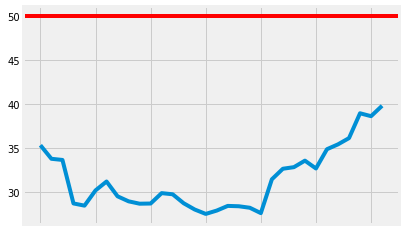

Predictions for Date: 2017-02-06 00:00:00 — Number of predictions: 33


2017-02-06
count   33.000000
mean    31.042121
std      4.060462
min     24.170000
25%     29.120000
50%     30.800000
75%     32.810000
max     40.160000

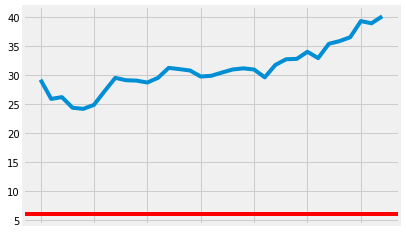

Predictions for Date: 2017-02-08 00:00:00 — Number of predictions: 34


2017-02-08
count   34.000000
mean    28.849706
std      6.632471
min      8.260000
25%     27.797500
50%     30.340000
75%     31.975000
max     39.330000

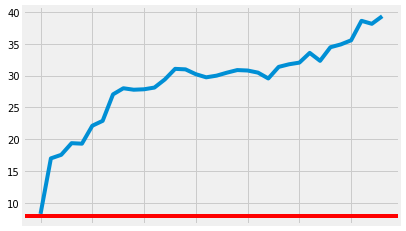

Predictions for Date: 2017-02-09 00:00:00 — Number of predictions: 35


2017-02-09
count   35.000000
mean    29.769143
std      5.672682
min     16.040000
25%     29.290000
50%     30.680000
75%     31.985000
max     39.750000

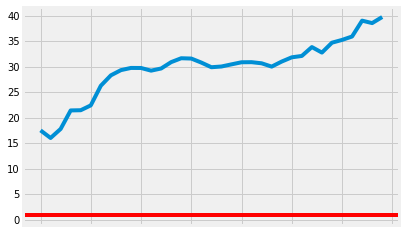

Predictions for Date: 2017-02-10 00:00:00 — Number of predictions: 36


2017-02-10
count   36.000000
mean    30.455278
std      4.620065
min     20.850000
25%     29.407500
50%     30.235000
75%     32.485000
max     39.820000

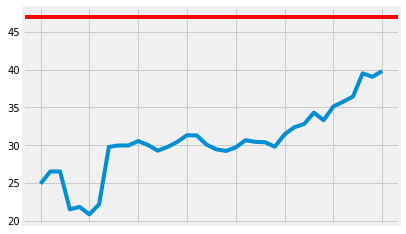

Predictions for Date: 2017-02-11 00:00:00 — Number of predictions: 37


2017-02-11
count   37.000000
mean    30.918649
std      3.566235
min     24.890000
25%     29.040000
50%     29.910000
75%     32.310000
max     40.140000

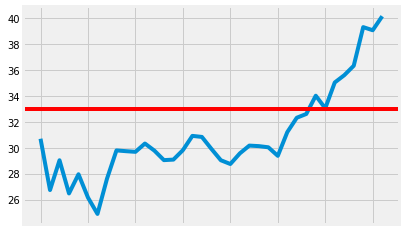

Predictions for Date: 2017-02-12 00:00:00 — Number of predictions: 38


2017-02-12
count   38.000000
mean    32.145263
std      3.215921
min     27.460000
25%     29.885000
50%     31.135000
75%     34.087500
max     40.130000

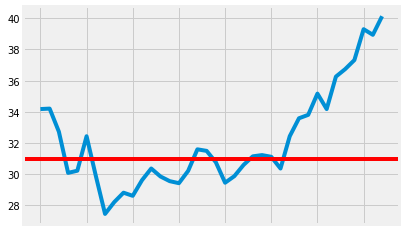

Predictions for Date: 2017-02-13 00:00:00 — Number of predictions: 39


2017-02-13
count   39.000000
mean    30.842821
std      3.705793
min     22.780000
25%     28.855000
50%     30.380000
75%     32.465000
max     39.670000

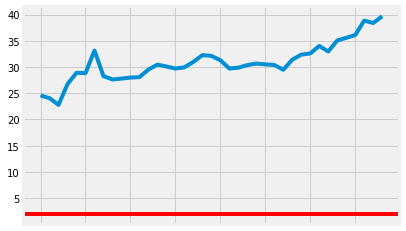

Predictions for Date: 2017-02-14 00:00:00 — Number of predictions: 40


2017-02-14
count   40.000000
mean    29.477750
std      5.601479
min     15.960000
25%     28.035000
50%     30.460000
75%     32.480000
max     39.640000

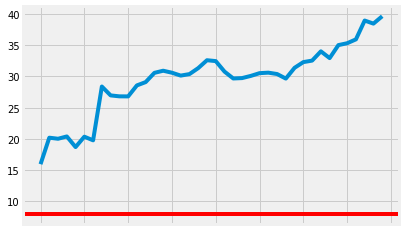

Predictions for Date: 2017-02-15 00:00:00 — Number of predictions: 40


2017-02-15
count    40.00000
mean     28.71575
std       6.06808
min      14.86000
25%      26.04500
50%      30.25500
75%      31.97000
max      39.18000

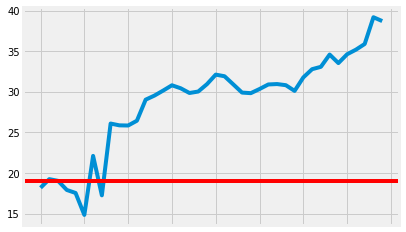

Predictions for Date: 2017-02-16 00:00:00 — Number of predictions: 40


2017-02-16
count   40.000000
mean    28.242750
std      4.665709
min     17.480000
25%     25.825000
50%     28.340000
75%     30.817500
max     39.310000

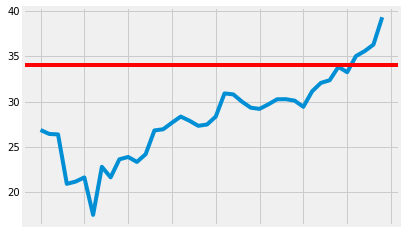

Predictions for Date: 2017-02-17 00:00:00 — Number of predictions: 40


2017-02-17
count   40.000000
mean    30.424750
std      3.013768
min     24.610000
25%     28.215000
50%     30.855000
75%     32.990000
max     36.380000

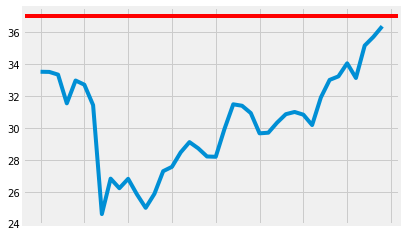

Predictions for Date: 2017-02-18 00:00:00 — Number of predictions: 40


2017-02-18
count   40.000000
mean    29.202750
std      2.806376
min     25.040000
25%     26.677500
50%     29.200000
75%     30.632500
max     35.760000

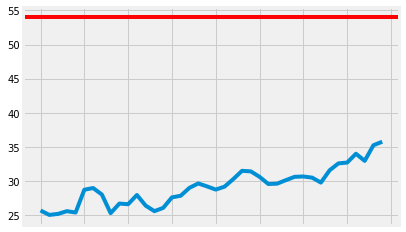

Predictions for Date: 2017-02-19 00:00:00 — Number of predictions: 40


2017-02-19
count   40.000000
mean    28.914000
std      3.403503
min     20.720000
25%     27.532500
50%     29.795000
75%     30.990000
max     34.920000

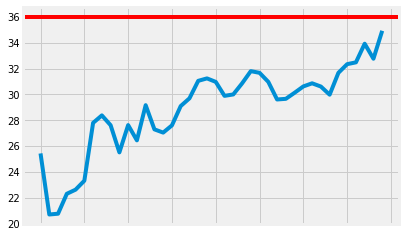

Predictions for Date: 2017-02-20 00:00:00 — Number of predictions: 40


2017-02-20
count   40.000000
mean    27.019250
std      5.861318
min     15.500000
25%     23.290000
50%     29.970000
75%     31.137500
max     34.160000

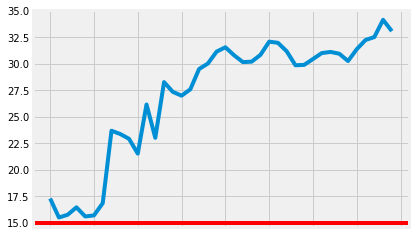

Predictions for Date: 2017-02-22 00:00:00 — Number of predictions: 40


2017-02-22
count   40.000000
mean    25.886250
std      5.653384
min     12.730000
25%     21.942500
50%     28.235000
75%     30.035000
max     34.030000

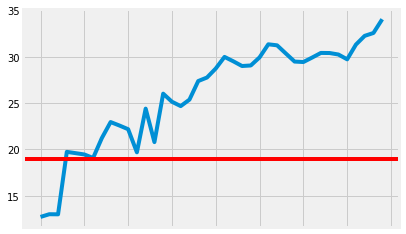

Predictions for Date: 2017-02-23 00:00:00 — Number of predictions: 40


2017-02-23
count   40.000000
mean    26.802250
std      3.517298
min     20.200000
25%     23.660000
50%     26.580000
75%     29.805000
max     32.650000

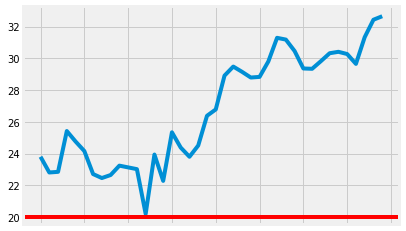

Predictions for Date: 2017-02-24 00:00:00 — Number of predictions: 40


2017-02-24
count   40.000000
mean    28.247250
std      2.665905
min     22.500000
25%     25.880000
50%     29.105000
75%     30.450000
max     32.530000

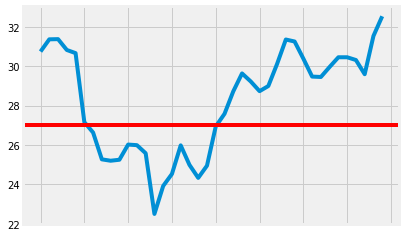

Predictions for Date: 2017-02-25 00:00:00 — Number of predictions: 40


2017-02-25
count    40.00000
mean     27.32625
std       3.12351
min      21.49000
25%      24.43000
50%      28.43500
75%      29.71750
max      31.48000

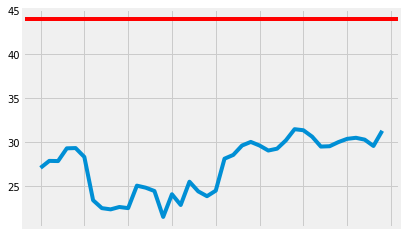

Predictions for Date: 2017-02-26 00:00:00 — Number of predictions: 40


2017-02-26
count   40.000000
mean    29.014500
std      3.395637
min     23.870000
25%     26.192500
50%     29.650000
75%     30.657500
max     37.770000

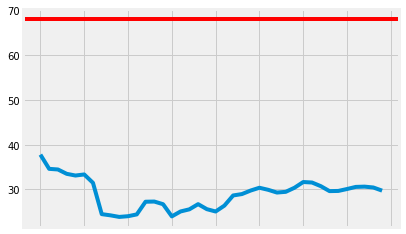

Predictions for Date: 2017-02-27 00:00:00 — Number of predictions: 40


2017-02-27
count   40.000000
mean    27.466500
std      2.996347
min     22.180000
25%     25.307500
50%     27.970000
75%     29.612500
max     34.440000

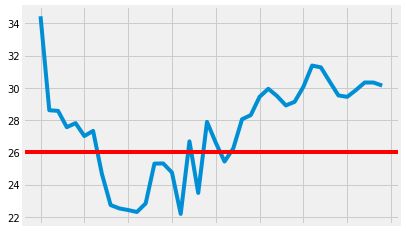

Predictions for Date: 2017-03-01 00:00:00 — Number of predictions: 40


2017-03-01
count   40.000000
mean    25.793250
std      3.578291
min     19.010000
25%     23.100000
50%     25.690000
75%     29.237500
max     31.090000

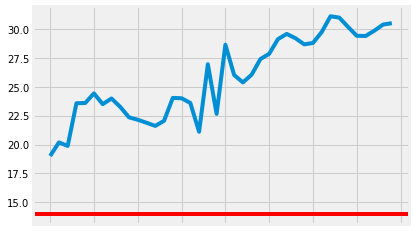

Predictions for Date: 2017-03-02 00:00:00 — Number of predictions: 40


2017-03-02
count   40.000000
mean    23.065000
std      5.776549
min     12.090000
25%     18.467500
50%     21.180000
75%     28.855000
max     31.090000

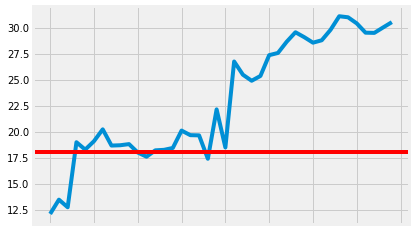

Predictions for Date: 2017-03-03 00:00:00 — Number of predictions: 40


2017-03-03
count   40.000000
mean    28.278250
std      2.461954
min     23.380000
25%     26.250000
50%     28.820000
75%     29.787500
max     33.430000

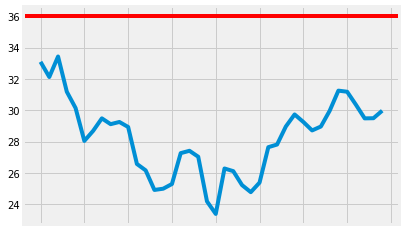

Predictions for Date: 2017-03-04 00:00:00 — Number of predictions: 40


2017-03-04
count   40.000000
mean    28.376750
std      3.313883
min     22.850000
25%     25.995000
50%     28.060000
75%     30.365000
max     35.230000

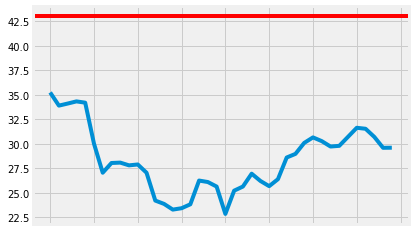

Predictions for Date: 2017-03-05 00:00:00 — Number of predictions: 40


2017-03-05
count   40.000000
mean    29.047750
std      4.235249
min     21.800000
25%     26.125000
50%     28.695000
75%     30.355000
max     38.400000

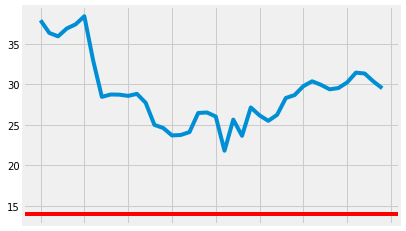

Predictions for Date: 2017-03-06 00:00:00 — Number of predictions: 40


2017-03-06
count   40.000000
mean    28.157000
std      4.194769
min     21.760000
25%     25.392500
50%     27.120000
75%     30.185000
max     36.720000

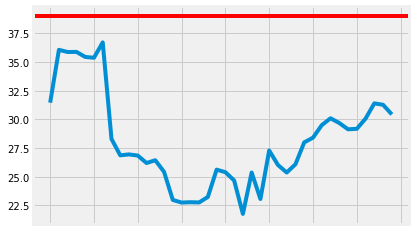

Predictions for Date: 2017-03-08 00:00:00 — Number of predictions: 40


2017-03-08
count   40.000000
mean    24.885750
std      3.071233
min     20.010000
25%     22.945000
50%     24.290000
75%     27.192500
max     31.350000

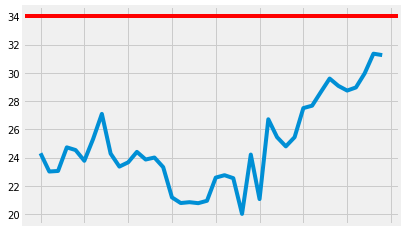

Predictions for Date: 2017-03-09 00:00:00 — Number of predictions: 40


2017-03-09
count   40.000000
mean    25.078593
std      3.050195
min     20.560000
25%     23.322500
50%     24.095000
75%     27.840000
max     31.300000

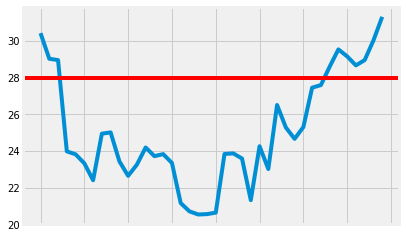

Predictions for Date: 2017-03-10 00:00:00 — Number of predictions: 40


2017-03-10
count   40.000000
mean    25.907085
std      2.652526
min     20.870000
25%     24.267500
50%     25.910400
75%     28.257500
max     30.290000

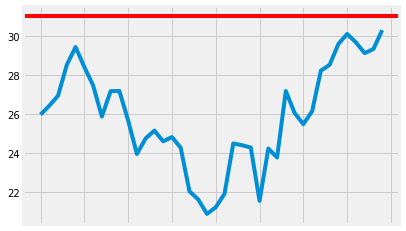

Predictions for Date: 2017-03-11 00:00:00 — Number of predictions: 40


2017-03-11
count   40.000000
mean    29.434648
std      3.274873
min     24.430000
25%     26.467500
50%     29.085000
75%     31.906425
max     37.070000

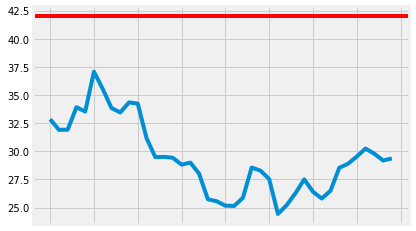

Predictions for Date: 2017-03-12 00:00:00 — Number of predictions: 40


2017-03-12
count   40.000000
mean    28.715162
std      3.613869
min     22.370000
25%     25.932500
50%     28.275000
75%     32.332500
max     36.040000

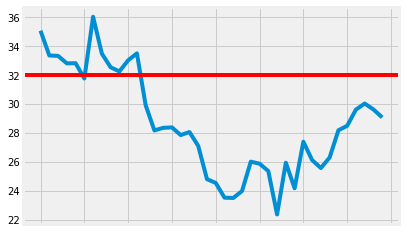

Predictions for Date: 2017-03-13 00:00:00 — Number of predictions: 40


2017-03-13
count   40.000000
mean    28.180367
std      2.731038
min     22.820000
25%     26.277500
50%     28.080000
75%     29.543050
max     33.890000

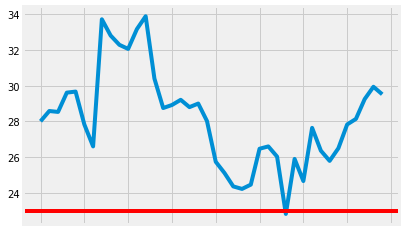

Predictions for Date: 2017-03-15 00:00:00 — Number of predictions: 40


2017-03-15
count   40.000000
mean    27.066248
std      3.826770
min     20.280000
25%     24.742500
50%     27.020000
75%     30.300000
max     33.016800

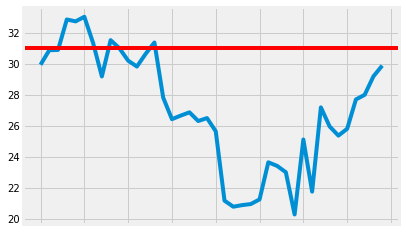

Predictions for Date: 2017-03-16 00:00:00 — Number of predictions: 40


2017-03-16
count   40.000000
mean    26.750145
std      3.538752
min     20.990000
25%     23.972500
50%     26.410000
75%     29.320000
max     32.672000

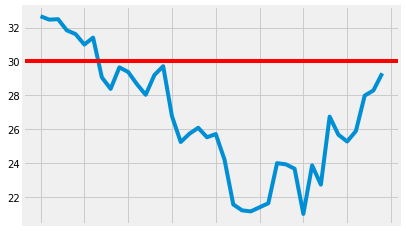

Predictions for Date: 2017-03-17 00:00:00 — Number of predictions: 40


2017-03-17
count   40.000000
mean    27.464442
std      3.233453
min     22.320000
25%     25.345000
50%     26.415000
75%     30.192500
max     33.043000

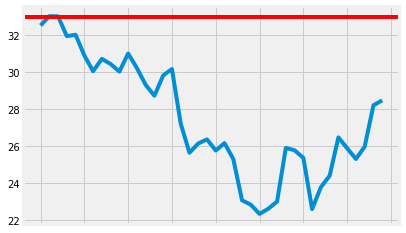

Predictions for Date: 2017-03-18 00:00:00 — Number of predictions: 40


2017-03-18
count   40.000000
mean    32.115865
std      4.428658
min     25.400000
25%     28.097500
50%     31.845000
75%     36.007025
max     38.693200

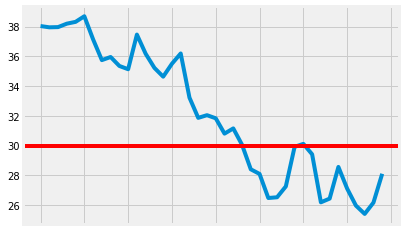

Predictions for Date: 2017-03-19 00:00:00 — Number of predictions: 40


2017-03-19
count   40.000000
mean    26.770722
std      3.136756
min     21.220000
25%     24.797500
50%     26.295000
75%     29.460000
max     31.690800

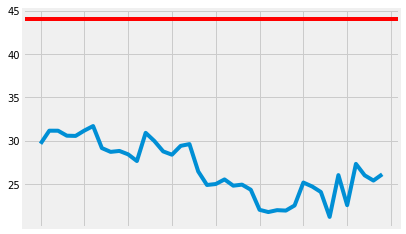

Predictions for Date: 2017-03-20 00:00:00 — Number of predictions: 40


2017-03-20
count   40.000000
mean    27.328330
std      2.996515
min     21.560000
25%     25.072500
50%     27.425000
75%     29.750975
max     32.036700

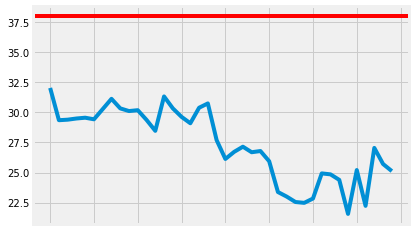

Predictions for Date: 2017-03-22 00:00:00 — Number of predictions: 40


2017-03-22
count   40.000000
mean    27.990633
std      3.568593
min     22.250000
25%     24.932500
50%     29.215000
75%     31.500025
max     33.033000

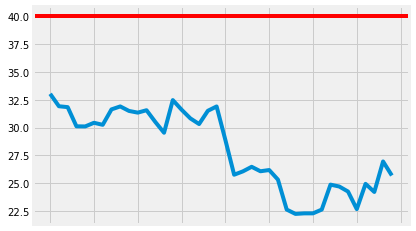

Predictions for Date: 2017-03-23 00:00:00 — Number of predictions: 40


2017-03-23
count   40.000000
mean    29.278910
std      4.773218
min     21.600000
25%     24.762500
50%     30.891700
75%     33.984850
max     34.815200

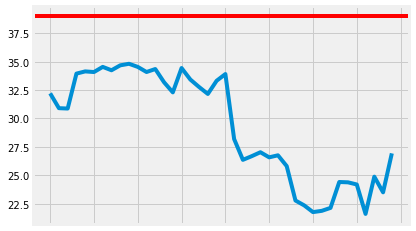

Predictions for Date: 2017-03-24 00:00:00 — Number of predictions: 40


2017-03-24
count   40.000000
mean    30.143165
std      3.675314
min     23.520000
25%     27.105000
50%     31.723150
75%     33.259625
max     34.554900

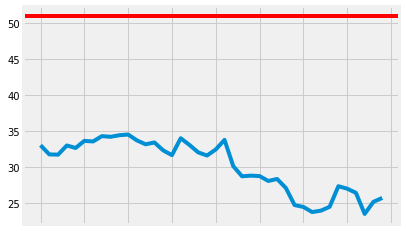

Predictions for Date: 2017-03-25 00:00:00 — Number of predictions: 40


2017-03-25
count   40.000000
mean    30.724757
std      3.718559
min     22.990000
25%     27.525000
50%     32.215000
75%     33.714850
max     36.569500

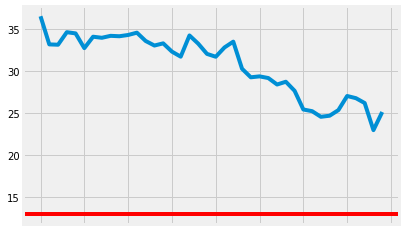

Predictions for Date: 2017-03-26 00:00:00 — Number of predictions: 40


2017-03-26
count   40.000000
mean    32.160238
std      3.733316
min     24.350000
25%     29.537500
50%     33.497150
75%     35.456750
max     36.698000

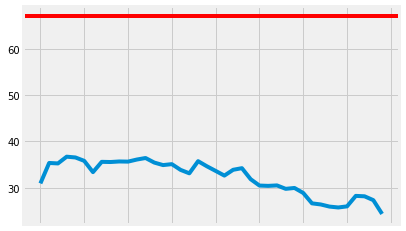

Predictions for Date: 2017-03-27 00:00:00 — Number of predictions: 40


2017-03-27
count   40.000000
mean    26.521795
std      3.887909
min     20.130000
25%     23.522500
50%     27.409650
75%     28.215200
max     36.117500

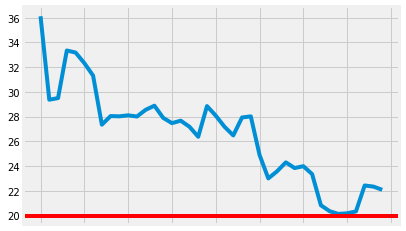

Predictions for Date: 2017-03-29 00:00:00 — Number of predictions: 40


2017-03-29
count   40.000000
mean    29.138262
std      4.729091
min     21.700000
25%     25.310000
50%     29.847450
75%     31.067975
max     40.604700

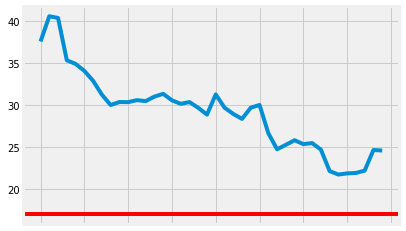

Predictions for Date: 2017-03-30 00:00:00 — Number of predictions: 40


2017-03-30
count   40.000000
mean    26.360825
std      3.185214
min     20.910000
25%     24.275000
50%     26.887350
75%     28.042575
max     33.220300

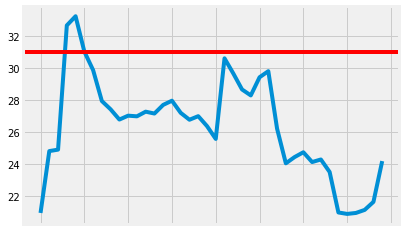

Predictions for Date: 2017-03-31 00:00:00 — Number of predictions: 40


2017-03-31
count   40.000000
mean    30.938543
std      4.177978
min     24.010000
25%     27.000000
50%     31.751250
75%     32.430175
max     40.822600

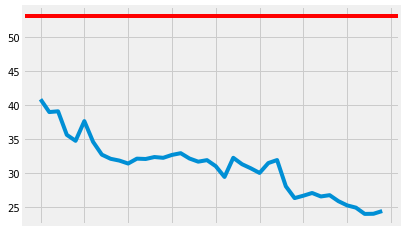

Predictions for Date: 2017-04-01 00:00:00 — Number of predictions: 40


2017-04-01
count   40.000000
mean    33.475718
std      5.485280
min     24.510000
25%     29.412500
50%     33.765650
75%     35.017000
max     47.604600

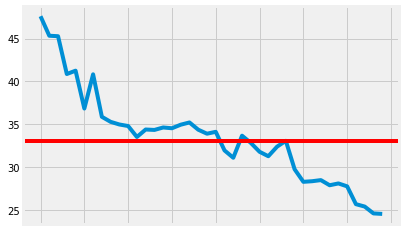

Predictions for Date: 2017-04-02 00:00:00 — Number of predictions: 40


2017-04-02
count   40.000000
mean    31.679295
std      3.283279
min     23.790000
25%     29.451600
50%     32.625000
75%     33.829175
max     36.880900

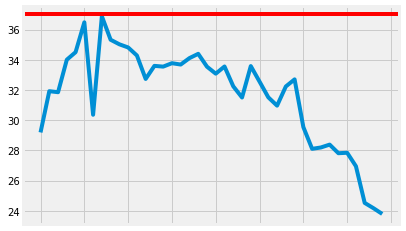

Predictions for Date: 2017-04-03 00:00:00 — Number of predictions: 40


2017-04-03
count   40.000000
mean    28.031433
std      3.944574
min     19.760000
25%     26.277500
50%     28.104350
75%     29.605125
max     39.011500

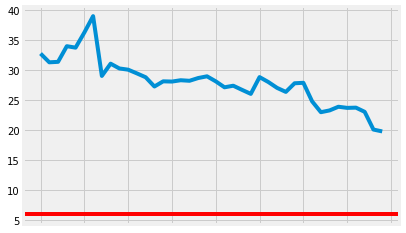

Predictions for Date: 2017-04-05 00:00:00 — Number of predictions: 40


2017-04-05
count   40.000000
mean    30.834763
std      2.777346
min     23.730000
25%     29.330650
50%     30.914650
75%     32.587875
max     37.229800

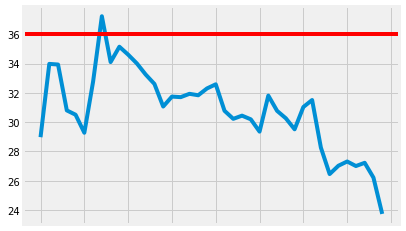

Predictions for Date: 2017-04-06 00:00:00 — Number of predictions: 40


2017-04-06
count   40.000000
mean    30.573175
std      2.571587
min     25.230000
25%     29.880825
50%     30.897350
75%     31.882225
max     36.081600

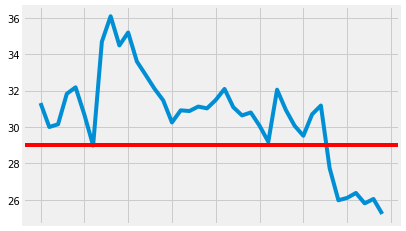

Predictions for Date: 2017-04-07 00:00:00 — Number of predictions: 40


2017-04-07
count   40.000000
mean    30.047740
std      3.103742
min     25.940000
25%     28.433900
50%     29.461050
75%     31.076400
max     38.463800

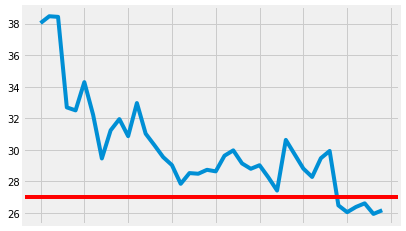

Predictions for Date: 2017-04-08 00:00:00 — Number of predictions: 40


2017-04-08
count   40.000000
mean    29.889990
std      2.557250
min     26.360000
25%     28.210700
50%     28.986200
75%     32.216075
max     36.313700

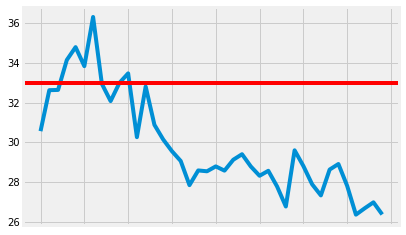

Predictions for Date: 2017-04-09 00:00:00 — Number of predictions: 40


2017-04-09
count   40.000000
mean    30.368475
std      2.402877
min     24.940000
25%     29.305000
50%     30.104000
75%     31.294750
max     35.619600

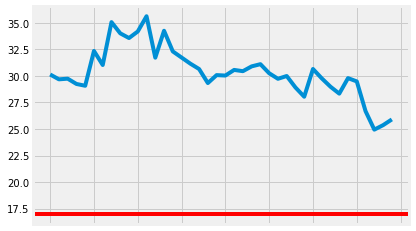

Predictions for Date: 2017-04-10 00:00:00 — Number of predictions: 40


2017-04-10
count   40.000000
mean    30.294185
std      2.174080
min     24.400000
25%     29.420350
50%     30.152000
75%     31.709800
max     35.244400

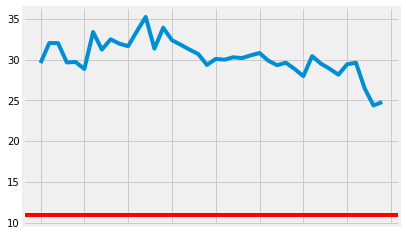

Predictions for Date: 2017-04-11 00:00:00 — Number of predictions: 40


2017-04-11
count    40.00000
mean     25.57271
std       2.77100
min      17.53330
25%      24.53835
50%      26.20115
75%      27.13420
max      31.04180

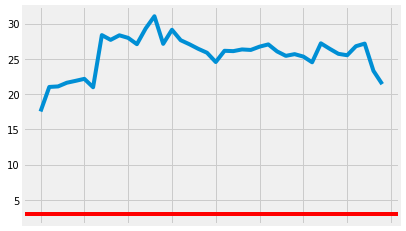

Predictions for Date: 2017-04-12 00:00:00 — Number of predictions: 40


2017-04-12
count   40.000000
mean    35.715183
std      2.461134
min     30.880000
25%     33.713900
50%     36.124200
75%     37.804675
max     40.452400

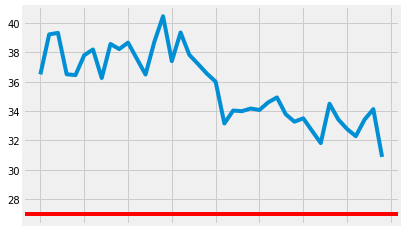

Predictions for Date: 2017-04-13 00:00:00 — Number of predictions: 40


2017-04-13
count   40.000000
mean    33.132728
std      1.961270
min     29.600000
25%     31.606325
50%     32.399900
75%     34.636100
max     37.429600

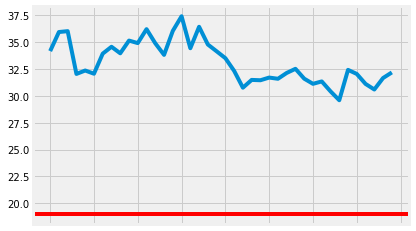

Predictions for Date: 2017-04-14 00:00:00 — Number of predictions: 40


2017-04-14
count   40.000000
mean    34.914785
std      2.439858
min     30.160000
25%     33.161600
50%     34.442150
75%     37.157150
max     39.667600

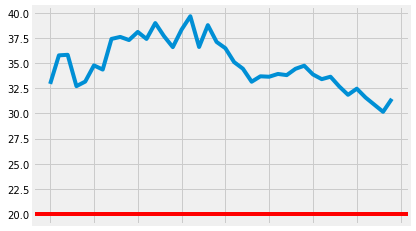

Predictions for Date: 2017-04-15 00:00:00 — Number of predictions: 40


2017-04-15
count   40.000000
mean    30.094838
std      2.197295
min     25.421700
25%     28.639125
50%     29.818700
75%     31.257075
max     34.935200

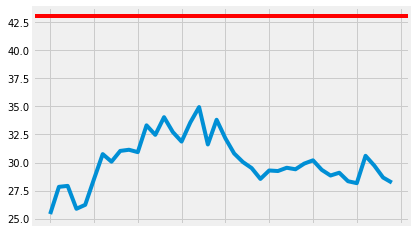

Predictions for Date: 2017-04-16 00:00:00 — Number of predictions: 40


2017-04-16
count   40.000000
mean    28.903210
std      3.061833
min     21.416800
25%     27.811100
50%     28.676500
75%     30.512250
max     34.948900

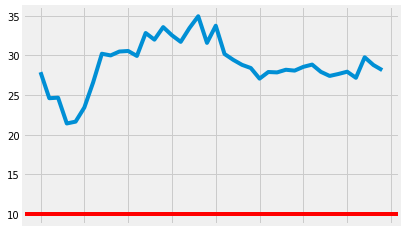

Predictions for Date: 2017-04-17 00:00:00 — Number of predictions: 40


2017-04-17
count   40.000000
mean    26.829450
std      4.281706
min     16.163100
25%     26.796850
50%     28.288350
75%     29.234600
max     32.768700

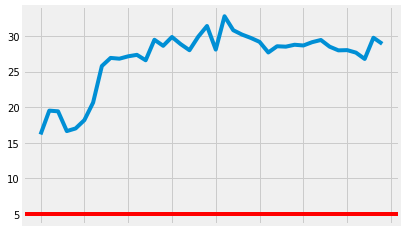

Predictions for Date: 2017-04-19 00:00:00 — Number of predictions: 40


2017-04-19
count   40.000000
mean    32.422428
std      4.837229
min     19.069900
25%     31.616125
50%     32.706550
75%     35.506850
max     40.321600

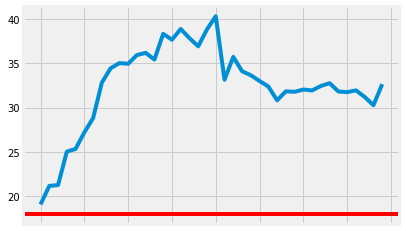

Predictions for Date: 2017-04-20 00:00:00 — Number of predictions: 40


2017-04-20
count   40.000000
mean    31.181110
std      3.491955
min     22.052000
25%     30.698550
50%     31.960150
75%     33.329375
max     37.685100

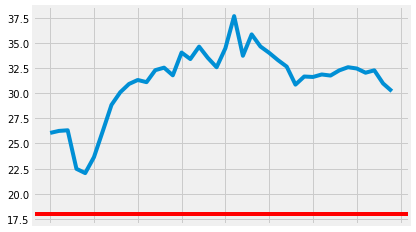

Predictions for Date: 2017-04-21 00:00:00 — Number of predictions: 40


2017-04-21
count   40.000000
mean    30.391285
std      3.940344
min     20.808100
25%     29.089925
50%     31.373150
75%     32.581775
max     37.676300

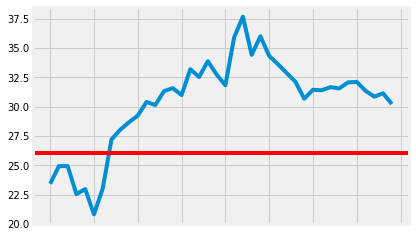

Predictions for Date: 2017-04-22 00:00:00 — Number of predictions: 40


2017-04-22
count   40.000000
mean    33.919625
std      3.662021
min     26.434600
25%     32.073625
50%     34.624350
75%     36.427325
max     39.325300

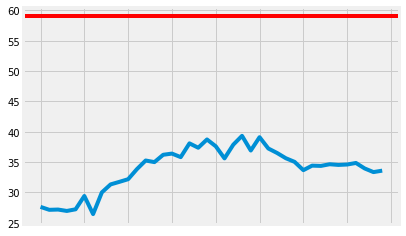

In [26]:
_ = historical_prediction_output.plot(label='Prediction Trends', ax=ax)
days_out_col_names = [f"{n}_days_out_prediction" for n in range(1,41)]

for i in historical_prediction_output[['visitors', '1_days_out_prediction']].dropna(axis=0, how='any').index:
    print(f"Predictions for Date: {i} — Number of predictions: {len(historical_prediction_output.loc[i, days_out_col_names].dropna(axis=0, how='any'))}")
#     display(pd.DataFrame(historical_prediction_output.loc[i, days_out_col_names].dropna(axis=0, how='any')))
    display(pd.DataFrame(pd.to_numeric(historical_prediction_output.loc[i, days_out_col_names].dropna(axis=0, how='any'))).describe(include = [np.number]))
    _ = historical_prediction_output.loc[i, days_out_col_names].plot.line()
    _ = plt.axhline(y=historical_prediction_output.loc[i, 'visitors'], color='r', linestyle='-')
    _ = plt.show()

Comparison of the progression of RMS values for prediction_length windows vs. RMS for entire 1-day-out series.


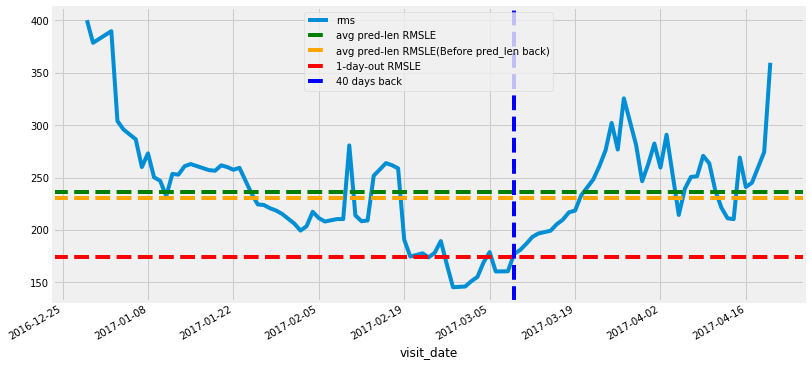

Comparison of the progression of RMSLE values for prediction_length windows vs. RMSLE for entire 1-day-out series.


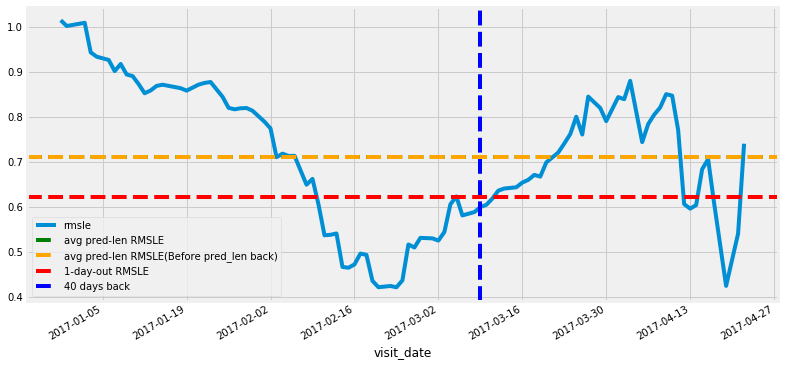

In [27]:
_ = historical_prediction_output.plot(label='Prediction Trends', ax=ax)
days_out_col_names = [f"{n}_days_out_prediction" for n in range(1,41)]

non_null_pred_df = pd.DataFrame(historical_prediction_output[['visitors', '1_days_out_prediction']].dropna(axis=0, how='any'))
print("Comparison of the progression of RMS values for prediction_length windows vs. RMS for entire 1-day-out series.")
_ = historical_prediction_output['rms'][:-2].plot.line(figsize=(12, 6))
_ = plt.axhline(y=historical_prediction_output['rms'][:-2].mean(), color='g', linestyle='--', label='avg pred-len RMSLE')
_ = plt.axhline(y=historical_prediction_output['rms'][:-40].mean(), color='orange', linestyle='--', label='avg pred-len RMSLE(Before pred_len back)')
_ = plt.axhline(y=rms(non_null_pred_df['visitors'], non_null_pred_df['1_days_out_prediction']), color='r', linestyle='--', label='1-day-out RMSLE')
_ = plt.axvline(x=historical_prediction_output.index[-40], color='b', linestyle='--', label='40 days back')
_ = plt.legend(loc='best')
_ = plt.show()
print("Comparison of the progression of RMSLE values for prediction_length windows vs. RMSLE for entire 1-day-out series.")
_ = historical_prediction_output['rmsle'].plot.line(figsize=(12, 6))
_ = plt.axhline(y=historical_prediction_output['rmsle'].mean(), color='g', linestyle='--', label='avg pred-len RMSLE')
_ = plt.axhline(y=historical_prediction_output['rmsle'][:-40].mean(), color='orange', linestyle='--', label='avg pred-len RMSLE(Before pred_len back)')
_ = plt.axhline(y=rmsle(non_null_pred_df['visitors'], non_null_pred_df['1_days_out_prediction']), color='r', linestyle='--', label='1-day-out RMSLE')
_ = plt.axvline(x=historical_prediction_output.index[-40], color='b', linestyle='--', label='40 days back')
_ = plt.legend(loc='best')
_ = plt.show()

Let's build the loop to parameter tune via these new 40-day windows. Note, it would take about two years to do all of the above for every series for even diameter two, so we are going to utilize the above analysis and instead restrict the `models_to_try` to a short list, and run this on them.

In [28]:
import timeit

In [31]:
def parameter_search_via_pred_windows(series, num_models, models_to_try):
  models =[]
  pred_df_dict_by_params = {}
  for i in models_to_try:
    ord_param, sord_param = i
    print (f"{ord_param}-{sord_param}")
    try:
        pred_df_dict_by_params[f"{ord_param}-{sord_param}"] = build_historical_prediction_dataframe(ord_param, sord_param, models, series, 'visitors', 40, 100, False)
    except:
        continue
  return pred_df_dict_by_params

In [32]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
rerun = True
if rerun:
    parameter_search_via_pred_windows(test, 5, [((1,1,1),(1,1,1,7))])

(1, 1, 1)-(1, 1, 1, 7)
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2073.23247 - RMS:174.87094 - RMSLE:0.61122
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2066.30165 - RMS:175.43481 - RMSLE:0.61214
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2058.90926 - RMS:195.87014 - RMSLE:0.63994
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2051.98796 - RMS:191.38809 - RMSLE:0.63146
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2043.16293 - RMS:179.79633 - RMSLE:0.57536
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2034.22047 - RMS:168.19700 - RMSLE:0.55186
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2027.01014 - RMS:173.83425 - RMSLE:0.56423
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2019.58901 - RMS:172.53774 - RMSLE:0.56380
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2011.97199 - RMS:178.73373 - RMSLE:0.55543
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2005.04300 - RMS:180.43988 - RMSLE:0.55203
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predict

{'(1, 1, 1)-(1, 1, 1, 7)':                     air_store_id  visit_date  visitors  \
 visit_date                                               
 2016-07-01  air_0f0cdeee6c9bf3d7  2016-07-01        18   
 2016-07-02  air_0f0cdeee6c9bf3d7  2016-07-02        37   
 2016-07-03  air_0f0cdeee6c9bf3d7  2016-07-03        20   
 2016-07-04  air_0f0cdeee6c9bf3d7  2016-07-04        16   
 2016-07-05  air_0f0cdeee6c9bf3d7  2016-07-05        15   
 2016-07-06  air_0f0cdeee6c9bf3d7  2016-07-06        16   
 2016-07-07  air_0f0cdeee6c9bf3d7  2016-07-07        17   
 2016-07-08  air_0f0cdeee6c9bf3d7  2016-07-08        22   
 2016-07-09  air_0f0cdeee6c9bf3d7  2016-07-09        27   
 2016-07-10  air_0f0cdeee6c9bf3d7  2016-07-10        22   
 2016-07-11  air_0f0cdeee6c9bf3d7  2016-07-11        15   
 2016-07-12  air_0f0cdeee6c9bf3d7  2016-07-12        13   
 2016-07-13  air_0f0cdeee6c9bf3d7  2016-07-13         9   
 2016-07-14  air_0f0cdeee6c9bf3d7  2016-07-14        16   
 2016-07-15  air_0f0cdeee6c9bf

In [511]:
mods

{'(1, 1, 1)-(1, 1, 1, 7)':                     air_store_id  visit_date  visitors  \
 visit_date                                               
 2016-07-01  air_0f0cdeee6c9bf3d7  2016-07-01        18   
 2016-07-02  air_0f0cdeee6c9bf3d7  2016-07-02        37   
 2016-07-03  air_0f0cdeee6c9bf3d7  2016-07-03        20   
 2016-07-04  air_0f0cdeee6c9bf3d7  2016-07-04        16   
 2016-07-05  air_0f0cdeee6c9bf3d7  2016-07-05        15   
 2016-07-06  air_0f0cdeee6c9bf3d7  2016-07-06        16   
 2016-07-07  air_0f0cdeee6c9bf3d7  2016-07-07        17   
 2016-07-08  air_0f0cdeee6c9bf3d7  2016-07-08        22   
 2016-07-09  air_0f0cdeee6c9bf3d7  2016-07-09        27   
 2016-07-10  air_0f0cdeee6c9bf3d7  2016-07-10        22   
 2016-07-11  air_0f0cdeee6c9bf3d7  2016-07-11        15   
 2016-07-12  air_0f0cdeee6c9bf3d7  2016-07-12        13   
 2016-07-13  air_0f0cdeee6c9bf3d7  2016-07-13         9   
 2016-07-14  air_0f0cdeee6c9bf3d7  2016-07-14        16   
 2016-07-15  air_0f0cdeee6c9bf

# Future forecasts

Let's build forecasts for the future, and put them into the right format for submission

In [159]:
def forecast_future(ords, sords, series, col_name, forecast_length=40, dynamic_predictions=False, quiet=False):
#   try:
  predictions_output = series.copy()
  last = len(series)-1
  days_to_forecast = [(predictions_output.index[-1] + relativedelta(days=i)) for i in range(forecast_length+1)]
#   print(last, days_to_forecast[0], series.index[-1])
#   print(series.iloc[last])
  mod = sm.tsa.statespace.SARIMAX(
      series[col_name], trend='n', order=ords, seasonal_order=sords
    )
  res = mod.fit()
  predictions_frame = res.predict(start = last, end= last+forecast_length, dynamic= dynamic_predictions)
#   print(predictions_frame.index[0])
  predictions_frame.index = days_to_forecast
  predictions_output = pd.merge(
    left=predictions_output,
    right=pd.DataFrame(predictions_frame, columns=['forecasts']),
    right_index=True,
    left_index=True,
    how='outer'
  )
  predictions_output['air_store_id']=predictions_output['air_store_id'].fillna(method='ffill')
  predictions_output['submission_id'] = [predictions_output['air_store_id'].values[0]+'_'+date.strftime('%Y-%m-%d') for date in list(predictions_output.index)]
  if not quiet:
      print('ARIMA{}x{} - predictions:{} - AIC:{:03.5f}'.format(
            ords, 
            sords, 
            forecast_length,
            res.aic
        )
      )  
  return predictions_output
#   except:
#     pass

ARIMA(3, 1, 1)x(2, 0, 3, 7) - predictions:40 - AIC:1777.35860


forecasts                    submission_id
2017-04-23  17.638438  air_00a91d42b08b08d9_2017-04-23
2017-04-24  23.647601  air_00a91d42b08b08d9_2017-04-24
2017-04-25  27.331562  air_00a91d42b08b08d9_2017-04-25
2017-04-26  29.096776  air_00a91d42b08b08d9_2017-04-26
2017-04-27  32.367962  air_00a91d42b08b08d9_2017-04-27
2017-04-28  39.660862  air_00a91d42b08b08d9_2017-04-28
2017-04-29  17.976670  air_00a91d42b08b08d9_2017-04-29
2017-04-30  17.846156  air_00a91d42b08b08d9_2017-04-30
2017-05-01  25.114463  air_00a91d42b08b08d9_2017-05-01
2017-05-02  27.117514  air_00a91d42b08b08d9_2017-05-02
2017-05-03  29.722428  air_00a91d42b08b08d9_2017-05-03
2017-05-04  31.977751  air_00a91d42b08b08d9_2017-05-04
2017-05-05  37.978106  air_00a91d42b08b08d9_2017-05-05
2017-05-06  17.285121  air_00a91d42b08b08d9_2017-05-06
2017-05-07  17.764459  air_00a91d42b08b08d9_2017-05-07
2017-05-08  25.609497  air_00a91d42b08b08d9_2017-05-08
2017-05-09  27.271451  air_00a91d42b08b08d9_2017-05-09
2017-05-10  30.309348  air_00a91d42b08b08d9_2017-05-10
2017-05-11  31.986984  air_00a91d42b08b08d9_2017-05-11
2017-05-12  38.458642  air_00a91d42b08b08d9_2017-05-12
2017-05-13  18.077374  air_00a91d42b08b08d9_2017-05-13
2017-05-14  18.046781  air_00a91d42b08b08d9_2017-05-14
2017-05-15  25.420792  air_00a91d42b08b08d9_2017-05-15
2017-05-16  27.328924  air_00a91d42b08b08d9_2017-05-16
2017-05-17  29.921453  air_00a91d42b08b08d9_2017-05-17
2017-05-18  32.147006  air_00a91d42b08b08d9_2017-05-18
2017-05-19  38.151030  air_00a91d42b08b08d9_2017-05-19
2017-05-20  17.504264  air_00a91d42b08b08d9_2017-05-20
2017-05-21  17.973233  air_00a91d42b08b08d9_2017-05-21
2017-05-22  25.793719  air_00a91d42b08b08d9_2017-05-22
2017-05-23  27.457797  air_00a91d42b08b08d9_2017-05-23
2017-05-24  30.480447  air_00a91d42b08b08d9_2017-05-24
2017-05-25  32.166764  air_00a91d42b08b08d9_2017-05-25
2017-05-26  38.616570  air_00a91d42b08b08d9_2017-05-26
2017-05-27  18.266842  air_00a91d42b08b08d9_2017-05-27
2017-05-28  18.247029  air_00a91d42b08b08d9_2017-05-28
2017-05-29  25.617154  air_00a91d42b08b08d9_2017-05-29
2017-05-30  27.516562  air_00a91d42b08b08d9_2017-05-30
2017-05-31  30.113586  air_00a91d42b08b08d9_2017-05-31
2017-06-01  32.323502  air_00a91d42b08b08d9_2017-06-01

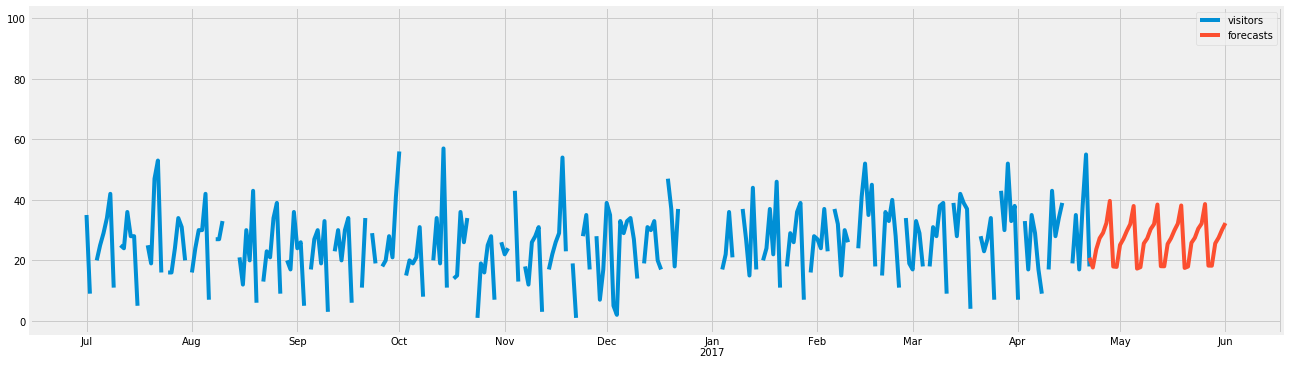

In [250]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    future_output = forecast_future((3, 1, 1),(2, 0, 3, 7),test, 'visitors')
    # future_output.predicted_mean
    display(future_output[['forecasts', 'submission_id']].dropna()[1:])
    future_output[['visitors', 'forecasts']].plot.line(figsize=(20, 6))

In [275]:
target_days = list(future_output[['forecasts', 'submission_id']].dropna()[1:-1].index)

# Now the big iteration to generate output for the competition


In [238]:
test_set_ids = []
with open('../public/competition_id_list.txt') as f:
    test_set_ids = [l.strip('\n') for l in f]

In [387]:
parameter_search_metrics_dict = {}
global_predictions_df = pd.DataFrame()
DIAMETER = 3
for idx, air_id in enumerate(test_set_ids):
    print(f"Starting analysis for {air_id}; number {idx + 1} of {len(test_set_ids)}")
    future_predictions_by_air_id = None
    air_loc_dataseries = air_visit_data_datefill[
        air_visit_data_datefill['air_store_id'] == air_id
    ]
    air_loc_dataseries.set_index('visit_date', inplace=True)
    parameter_search_mods = parameter_search2(air_loc_dataseries['visitors'], 5, DIAMETER)
    parameter_search_metrics_dict[air_id] = {
        'aic': [(i[0],i[1],i[2]) for i in sorted(parameter_search_mods[1], key=lambda x: x[2])[:5]],
        'rms': [(i[0],i[1],i[3]) for i in sorted(parameter_search_mods[1], key=lambda x: x[3])[:5]],
        'rmsle': [(i[0],i[1],i[4]) for i in sorted(parameter_search_mods[1], key=lambda x: x[4])[:5]]
    }
    for i in range(5):
        try:
            best_ords, best_sords = parameter_search_metrics_dict[air_id]['rmsle'][i][0:2]
            future_predictions_by_air_id = forecast_future(best_ords, best_sords, air_loc_dataseries, 'visitors')
            global_predictions_df = global_predictions_df.append(
                future_predictions_by_air_id[['forecasts', 'submission_id']].dropna()[1:].loc[target_days]
            )
            break
        except Exception as e:
            print(f"Exception: {e}")
    if future_predictions_by_air_id is None:
        for j in range(5):
            try:
                best_ords, best_sords = parameter_search_metrics_dict[air_id]['rms'][i][0:2]
                future_predictions_by_air_id = forecast_future(best_ords, best_sords, air_loc_dataseries, 'visitors')
                global_predictions_df = global_predictions_df.append(
                    future_predictions_by_air_id[['submission_id', 'forecasts']].dropna()[1:].loc[target_days]
                )
                break
            except Exception as e:
                print(f"Exception: {e}")
#     display(global_predictions_df)
        
    
#     _ = future_predictions_by_air_id[['visitors', 'forecasts']].plot.line(figsize=(20, 6))

Starting analysis for air_00a91d42b08b08d9; number 1 of 821
ARIMA(2, 1, 2)x(2, 1, 1, 7) - predictions:40 - AIC:1743.36511
Starting analysis for air_0164b9927d20bcc3; number 2 of 821
ARIMA(2, 1, 2)x(2, 0, 1, 7) - predictions:40 - AIC:985.98710
Starting analysis for air_0241aa3964b7f861; number 3 of 821


KeyboardInterrupt: 

In [333]:
len(global_predictions_df)

32019

In [340]:
global_predictions_df.columns = ['visitors', 'id']

In [341]:
global_predictions_df.head()

visitors                               id
2017-04-23   4.715778  air_00a91d42b08b08d9_2017-04-23
2017-04-24  24.939439  air_00a91d42b08b08d9_2017-04-24
2017-04-25  28.304054  air_00a91d42b08b08d9_2017-04-25
2017-04-26  29.478065  air_00a91d42b08b08d9_2017-04-26
2017-04-27  33.420321  air_00a91d42b08b08d9_2017-04-27

In [350]:
global_predictions_df.dropna().to_csv("submission_output", index=False)

In [367]:
clone_global_predictions_df = global_predictions_df.copy()

In [368]:
clone_global_predictions_df.iloc[[1559,1560,1561]]

visitors                               id
2017-05-31        NaN                              NaN
2017-04-23  48.248084  air_0e7c11b9abc50163_2017-04-23
2017-04-24  39.318796  air_0e7c11b9abc50163_2017-04-24

In [369]:
clone_global_predictions_df[clone_global_predictions_df.isnull().any(axis=1)]

visitors   id
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN
2017-05-31       NaN  NaN
2017-05-28       NaN  NaN
2017-05-29       NaN  NaN
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN
2017-05-31       NaN  NaN
2017-05-31       NaN  NaN
2017-05-29       NaN  NaN
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN
2017-05-28       NaN  NaN
2017-05-29       NaN  NaN
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN
2017-05-31       NaN  NaN
2017-05-31       NaN  NaN
2017-05-11       NaN  NaN
2017-05-12       NaN  NaN
2017-05-13       NaN  NaN
2017-05-14       NaN  NaN
2017-05-15       NaN  NaN
2017-05-16       NaN  NaN
2017-05-17       NaN  NaN
2017-05-18       NaN  NaN
2017-05-19       NaN  NaN
2017-05-20       NaN  NaN
2017-05-21       NaN  NaN
2017-05-22       NaN  NaN
2017-05-23       NaN  NaN
2017-05-24       NaN  NaN
2017-05-25       NaN  NaN
2017-05-26       NaN  NaN
2017-05-27       NaN  NaN
2017-05-28       NaN  NaN
2017-05-29       NaN  NaN
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN
2017-05-31       NaN  NaN
2017-05-27       NaN  NaN
2017-05-28       NaN  NaN
2017-05-29       NaN  NaN
2017-05-30       NaN  NaN
2017-05-31       NaN  NaN

In [370]:
clone_global_predictions_df = clone_global_predictions_df.fillna(method='ffill')

In [371]:
clone_global_predictions_df['id']= clone_global_predictions_df['id'].str[:-10] + clone_global_predictions_df.index.strftime('%Y-%m-%d')


In [375]:
clone_global_predictions_df[clone_global_predictions_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [visitors, id]
Index: []

In [385]:
# clone_global_predictions_df.where(clone_global_predictions_df['visitors']<0)
clone_global_predictions_df['visitors'] = clone_global_predictions_df['visitors'].clip(lower=0)

In [386]:
clone_global_predictions_df.to_csv("submission_output", index=False)

In [378]:
clone_global_predictions_df.to_csv("submission_output", index=False)

2017-04-23     4.715778
2017-04-24    24.939439
2017-04-25    28.304054
2017-04-26    29.478065
2017-04-27    33.420321
2017-04-28    41.621123
2017-04-29    18.207173
2017-04-30     4.962906
2017-05-01    25.700277
2017-05-02    27.712589
2017-05-03    30.940109
2017-05-04    33.055645
2017-05-05    40.314129
2017-05-06    18.355132
2017-05-07     5.115144
2017-05-08    25.907529
2017-05-09    27.775021
2017-05-10    31.222455
2017-05-11    33.142364
2017-05-12    40.299934
2017-05-13    18.496751
2017-05-14     5.257220
2017-05-15    26.055497
2017-05-16    27.907480
2017-05-17    31.378465
2017-05-18    33.277424
2017-05-19    40.424187
2017-05-20    18.637690
2017-05-21     5.398209
2017-05-22    26.197116
                ...    
2017-05-02     4.590362
2017-05-03     4.668391
2017-05-04     4.709777
2017-05-05     5.617063
2017-05-06     7.033920
2017-05-07     4.221890
2017-05-08     4.286869
2017-05-09     4.591252
2017-05-10     4.669120
2017-05-11     4.710420
2017-05-12     5